In [1]:
import pandas as pd
import numpy as np
import oracledb
from sqlalchemy import create_engine
import os
import glob
pd.set_option('display.max_columns',100)
import time
import seaborn as sns
import matplotlib.pyplot as plt

- Perfiorming: 0 DPD
- Grace Period: 1-29 DPD
- Delinquents: Accounts with >=30 days DPD

# A. Query Data

## 1. DBA Connection

In [ ]:
# credentials
usernameDBA = os.environ['DBA_USR']
passwordDBA = os.environ['DBA_PW']
dsnDBA = '10.220.50.121:1661/ANALYTIC'

In [3]:
# connection_string = f'oracle+oracledb://{username}:{password}@{host}:{port}/?service_name={service_name}'

In [ ]:
# create connection
connectionDBA = oracledb.connect(user=usernameDBA, password=passwordDBA, dsn=dsnDBA)

In [ ]:
# create engine
engineDBA = create_engine('oracle+oracledb://', creator=lambda: connectionDBA)

## 2. EDWB Connection

In [ ]:
# credentials
usernameEDWB = os.environ['UID']
passwordEDWB = os.environ['EDWB_PW']
dsnEDWB = '172.16.2.28:1521/brgprod'

In [ ]:
# create connection
connectionEDWB = oracledb.connect(user=usernameEDWB, password=passwordEDWB, dsn=dsnEDWB)

In [ ]:
# create engine
engineEDWB = create_engine('oracle+oracledb://', creator=lambda: connectionEDWB)

## 3. Run Query

In [6]:
# create list of all dates
allDates = ['20241129','20241031','20240930','20240829','20240731','20240628','20240531',
            '20240430','20240328','20240229','20240131','20231229','20231130']
# no dpd for <202404
# ['20241129','20241031','20240930','20240829','20240731','20240628','20240531',
#             '20240430','20240328','20240229','20240131','20231229','20231130']

In [ ]:
# open sql file 360
with open("CCPull_CUST360.sql", 'r') as file:
    query_360 = file.read()

# open sql PORTFOLIO
with open("CCPull_CUSTPORT.sql", 'r') as file:
    query_PORTFOLIO = file.read()

# open delq_history 
with open("DELQ_HIST.sql", 'r') as file:
    query_DELQ = file.read()

In [8]:
# print(query_template.format(dt='20241031'))

In [ ]:
allMLs = []
allPRs = []
for date in allDates:
    yearmonth = date[2:6]
    # query MLs, use customer portfolio if date >20240328 else 360
    if int(date) > 20240328:
        try:
            # print in case of errors
            print(f'Running ML Query {date}')

            # open and read the file as a single buffer
            sqlQuery = query_360.format(dt=date, ym=yearmonth)

            # run query and store data in df
            print('ML run')
            with engineDBA.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'ML {date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)
    else:
        try:
            # print in case of errors
            print(f'Running ML Query {date}')

            # open and read the file as a single buffer
            sqlQuery = query_PORTFOLIO.format(dt=date, ym=yearmonth)

            # run query and store data in df
            print('ML run')
            with engineDBA.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'ML {date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)
    
    # query payment ratio
    try:
        # print in case of errors
        print(f'Running Delq/Payment Ratio Query {date}')

        # open and read the file as a single buffer
        sqlQuery = query_DELQ.format(dt=date, ym=yearmonth)

        # run query and store data in df
        print('Delq/Payment Ratio run')
        with engineEDWB.connect() as connection:
            PR = pd.read_sql(sqlQuery, connection) 
        print(f'Delq/Payment Ratio {date} queried successfully')

        # change column names into UPPER CASE
        PR.columns = [x.upper() for x in PR.columns]
    except Exception as e:
            print(e)
            PR = pd.DataFrame()
    finally:
        allPRs.append(PR)

Running 20241129
SQL run


In [ ]:
allMLs[11]['MTD_MAX_BAL']

0            3747
1               0
2             785
3            7855
4               0
           ...   
262181       5000
262182          0
262183          0
262184          0
262185    5453350
Name: MTD_MAX_BAL, Length: 262186, dtype: int64

In [ ]:
# concat all MLs into one
MLs = pd.concat(allMLs, ignore_index=True)

# concat all PRs into one
PRs = pd.concat(allPRs, ignore_index=True)

C:\Users\MR38804\AppData\Local\Temp\ipykernel_2748\416592903.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  MLs = pd.concat(allMLs, ignore_index=True)
C:\Users\MR38804\AppData\Local\Temp\ipykernel_2748\416592903.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  MLs = pd.concat(allMLs, ignore_index=True)


In [ ]:
MLs['MTD_MAX_OS']=MLs['MTD_MAX_OS'].astype(float)
MLs['MTD_AVG_OS']=MLs['MTD_MAX_OS'].astype(float)

In [ ]:
# show all df cols
MLs.columns

Index(['GCIF_NO', 'CARD_NMBR', 'BASE_DT', 'AGREE_ID', 'GCIF_NO', 'CIF_NO',
       'NOTE_NO', 'PRD_TP', 'PRD_NM', 'PRD_SEGMENT', 'ORG_LMT_AMT',
       'CURR_LMT_AMT', 'BAL', 'ORIG_INT_RT', 'CURR_INT_RT', 'OTH_CURR_INT_RT',
       'LAST_RNWL_DT', 'ORIG_MAT_DT', 'CURR_MAT_DT', 'TENOR', 'DAYS_REMAIN',
       'CLCT_RTNG_FCL', 'ALLOW_PCT', 'ALLOW_PCT_ADD', 'RESTRUCT_CD',
       'PASTDUE_SINCE_DT', 'PASTDUE_DAYS', 'WRITE_OFF_AMT', 'WRITE_OFF_DT',
       'WRITE_OFF_YN', 'CC_STATUS', 'GCIF_NO', 'SEGMENT', 'CUST_NM',
       'OPEN_DATE', 'LAST_ACTIVE_DATE', 'CUST_TP', 'GENDER_CD', 'AGE',
       'SAGA_FLAG', 'EMPLOYMENT_TYPE', 'CA_BAL', 'CA_AVG', 'SA_BAL', 'SA_AVG',
       'TD_NOA', 'TD_BAL', 'TD_AVG', 'SY_FUNDING_BAL', 'SY_FUNDING_AVG',
       'FUNDING_NOA', 'FUNDING_BAL', 'FUNDING_AVG', 'NOA_DORMANT',
       'CC_PLAFOND', 'CC_BAL', 'PL_PLAFOND', 'PLOAN_BAL', 'TR_PLAFOND',
       'TR_BAL', 'PB_PLAFOND', 'PB_BAL', 'PRK_PLAFOND', 'PRK_BAL',
       'PPB_PLAFOND', 'PPB_BAL', 'BG_PLAFOND', 'BG_BAL', '

In [ ]:
PRs.columns

In [ ]:
# save df as pickle
MLs.to_pickle(r'D:\Work\SAGA CC Bad Debt\Data\ML_2311-2410_New.pkl')

# B. EDA

In [2]:
# read df as pickle
MLs = pd.read_pickle(r'D:\Work\SAGA CC Bad Debt\Data\ML_2311-2410_New.pkl')

In [3]:
# fix CC status
MLs['CC_STATUS']=MLs.apply(lambda x: 'PERFORMING' if x['PASTDUE_DAYS']==0 else 'GRACE PERIOD' if x['PASTDUE_DAYS']<30 else 'DELINQUENT', axis=1)

## 1. By Account

In [7]:
# drop in case of duplicated colname
MLs = MLs.loc[:, ~MLs.columns.duplicated()].copy()

In [8]:
MLs[['BAL','MTD_MAX_BAL']].describe()

,BAL
count,3.106710e+06
mean,6.502646e+06
std,2.007265e+07
min,0.000000e+00
25%,0.000000e+00
50%,9.202000e+03
75%,3.600112e+06
max,3.765936e+09


In [9]:
# check saga value count
MLs['SAGA_FLAG'].value_counts()

SAGA_FLAG
NON-SAGA    1680789
SAGA        1425921
Name: count, dtype: int64

In [154]:
MLs[MLs['BASE_DT']=='20241031'][['PASTDUE_DAYS','CC_STATUS']].value_counts()

PASTDUE_DAYS  CC_STATUS   
0             PERFORMING      253257
1             GRACE PERIOD      2997
30            DELINQUENT         678
60            DELINQUENT         482
90            DELINQUENT         383
120           DELINQUENT         263
150           DELINQUENT         236
180           DELINQUENT           1
Name: count, dtype: int64

In [153]:
MLs[(MLs['SAGA_FLAG']=='SAGA')&(MLs['BASE_DT']=='20241031')][['PASTDUE_DAYS','CC_STATUS']].value_counts()

PASTDUE_DAYS  CC_STATUS   
0             PERFORMING      112589
1             GRACE PERIOD      1333
30            DELINQUENT         291
60            DELINQUENT         184
90            DELINQUENT         140
150           DELINQUENT          86
120           DELINQUENT          81
Name: count, dtype: int64

### a. SAGA vs ALL Delinquency

In [155]:
# SAGA delinquency aggregate
SAGADeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['SAGA_FLAG']=='SAGA')][[
    'BASE_DT', 'AGREE_ID', 'MTD_MAX_BAL','BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          MTD_MAX_OS=('MTD_MAX_BAL','sum'),
                          OS=('BAL','sum')).reset_index()
SAGADeliCount['MICRO_SEGMENT'] = 'SAGA'
SAGADeliCount['CATEGORY'] = 'DELINQUENT'

In [156]:
SAGADeliCount

,BASE_DT,ACCT_COUNT,MTD_MAX_OS,OS,MICRO_SEGMENT,CATEGORY
0,20231130,1014,25497160999,2.549716e+10,SAGA,DELINQUENT
1,20231229,999,27613187317,2.761319e+10,SAGA,DELINQUENT
2,20240131,975,28340226675,2.834023e+10,SAGA,DELINQUENT
3,20240229,1011,27995200029,2.799520e+10,SAGA,DELINQUENT
4,20240328,1073,29237991788,2.923799e+10,SAGA,DELINQUENT
5,20240430,1000,31849696650,3.159923e+10,SAGA,DELINQUENT
6,20240531,1025,32786133940,3.249113e+10,SAGA,DELINQUENT
7,20240731,1049,33081562852,3.279947e+10,SAGA,DELINQUENT
8,20240829,960,32447834231,3.201994e+10,SAGA,DELINQUENT
9,20240930,831,29178868152,2.884839e+10,SAGA,DELINQUENT


In [14]:
# Total delinquency aggregate
TotalDeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT')][[
    'BASE_DT', 'AGREE_ID', 'MTD_MAX_BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          MTD_MAX_OS=('MTD_MAX_BAL','sum')).reset_index()
TotalDeliCount['MICRO_SEGMENT'] = 'ALL'
TotalDeliCount['CATEGORY'] = 'DELINQUENT'

In [15]:
TotalDeliCount

,BASE_DT,ACCT_COUNT,MTD_MAX_OS,MICRO_SEGMENT,CATEGORY
0,20231130,2494,51576027948,ALL,DELINQUENT
1,20231229,2350,51553105072,ALL,DELINQUENT
2,20240131,2242,52224245798,ALL,DELINQUENT
3,20240229,2387,54025926860,ALL,DELINQUENT
4,20240328,2484,57414201653,ALL,DELINQUENT
5,20240430,2303,61705001004,ALL,DELINQUENT
6,20240531,2317,61990248514,ALL,DELINQUENT
7,20240731,2422,63974078306,ALL,DELINQUENT
8,20240829,2353,64356784137,ALL,DELINQUENT
9,20240930,2095,59621858090,ALL,DELINQUENT


In [16]:
# concat deli count
AllDeliCount = pd.concat([SAGADeliCount, TotalDeliCount], ignore_index=True)

# format data
AllDeliCount['BASE_DT'] = AllDeliCount['BASE_DT'].str[2:6]

<Axes: title={'center': 'DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

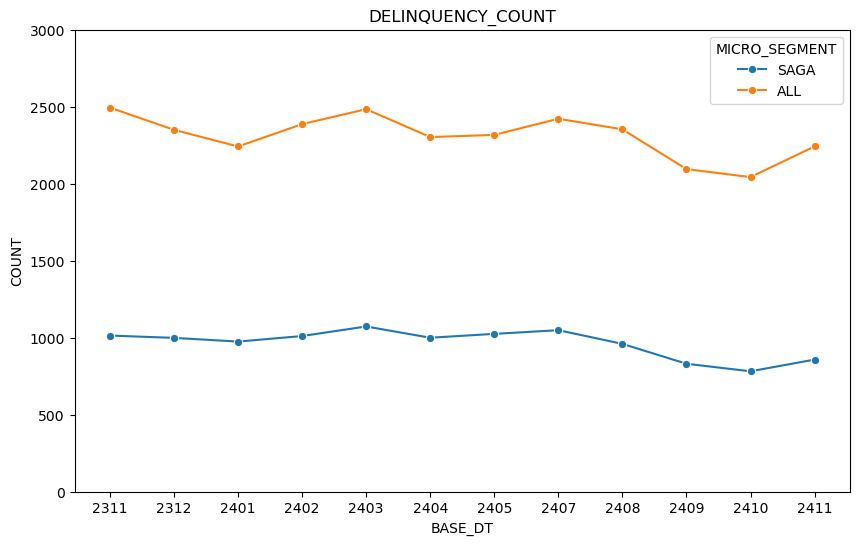

In [151]:
# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
plt.ylim((0,3000))
sns.lineplot(data=AllDeliCount, x="BASE_DT", y='ACCT_COUNT', hue='MICRO_SEGMENT', marker="o")

<Axes: title={'center': 'DELINQUENT_OS'}, xlabel='BASE_DT', ylabel='AMOUNT'>

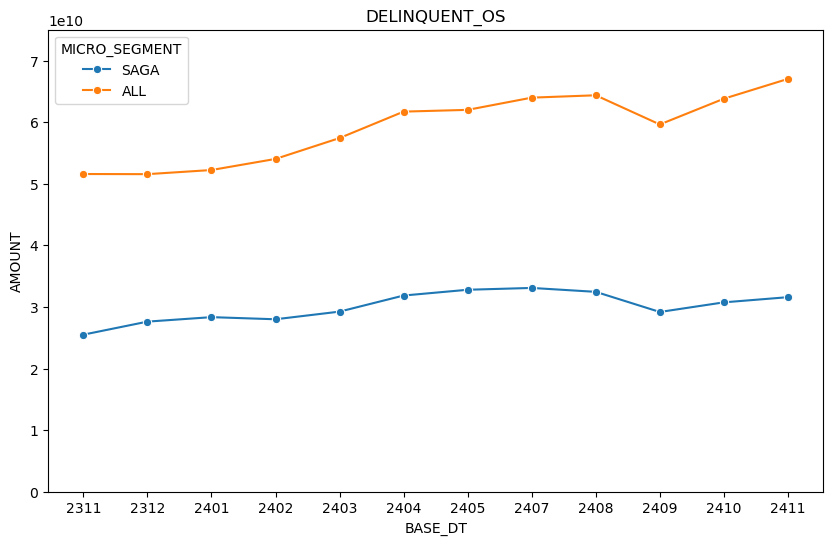

In [152]:
# Plot delinquent OS per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENT_OS")
plt.xlabel("BASE_DT")
plt.ylabel("AMOUNT")
plt.ylim((0,75000000000))
sns.lineplot(data=AllDeliCount, x="BASE_DT", y='MTD_MAX_OS', hue='MICRO_SEGMENT', marker="o")

In [19]:
AllDeliCount

,BASE_DT,ACCT_COUNT,MTD_MAX_OS,MICRO_SEGMENT,CATEGORY
0,2311,1014,25497160999,SAGA,DELINQUENT
1,2312,999,27613187317,SAGA,DELINQUENT
2,2401,975,28340226675,SAGA,DELINQUENT
3,2402,1011,27995200029,SAGA,DELINQUENT
4,2403,1073,29237991788,SAGA,DELINQUENT
5,2404,1000,31849696650,SAGA,DELINQUENT
6,2405,1025,32786133940,SAGA,DELINQUENT
7,2407,1049,33081562852,SAGA,DELINQUENT
8,2408,960,32447834231,SAGA,DELINQUENT
9,2409,831,29178868152,SAGA,DELINQUENT


In [20]:
# save AllDelicount as csv
AllDeliCount.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\SAGA & All Delinquency Count.csv')

### b. SAGA Total vs Delinquency

In [21]:
# Total delinquency aggregate
SAGACount = MLs[(MLs['SAGA_FLAG']=='SAGA')][[
    'BASE_DT', 'AGREE_ID', 'MTD_MAX_BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          MTD_MAX_OS=('MTD_MAX_BAL','sum')).reset_index()
SAGACount['MICRO_SEGMENT'] = 'SAGA'
SAGACount['CATEGORY'] = 'ALL'

In [22]:
# concat the data
AllSAGACount = pd.concat([SAGADeliCount, SAGACount], ignore_index=True)

# format base_dt
AllSAGACount['BASE_DT'] = AllSAGACount['BASE_DT'].str[2:6]

In [23]:
AllSAGACount

,BASE_DT,ACCT_COUNT,MTD_MAX_OS,MICRO_SEGMENT,CATEGORY
0,2311,1014,25497160999,SAGA,DELINQUENT
1,2312,999,27613187317,SAGA,DELINQUENT
2,2401,975,28340226675,SAGA,DELINQUENT
3,2402,1011,27995200029,SAGA,DELINQUENT
4,2403,1073,29237991788,SAGA,DELINQUENT
5,2404,1000,31849696650,SAGA,DELINQUENT
6,2405,1025,32786133940,SAGA,DELINQUENT
7,2407,1049,33081562852,SAGA,DELINQUENT
8,2408,960,32447834231,SAGA,DELINQUENT
9,2409,831,29178868152,SAGA,DELINQUENT


<Axes: title={'center': 'SAGA_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

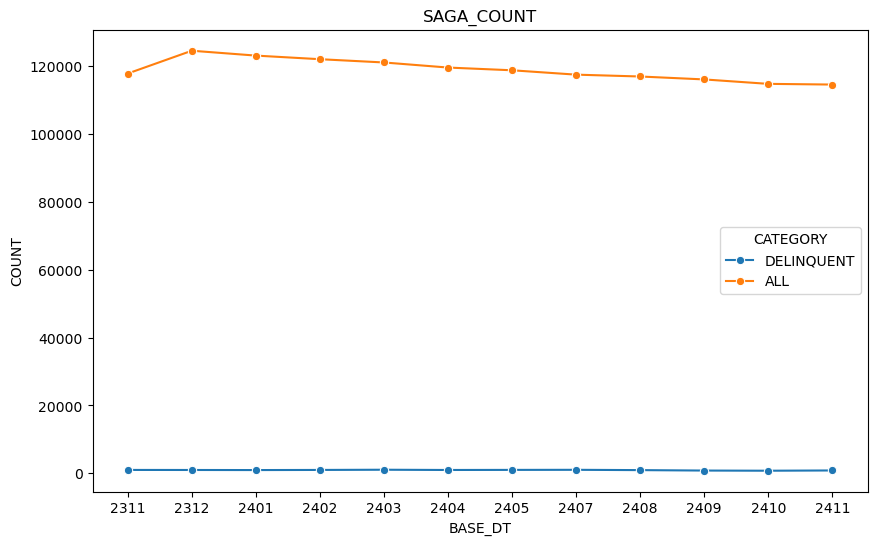

In [24]:
# Plot SAGA count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllSAGACount, x="BASE_DT", y='ACCT_COUNT', hue='CATEGORY', marker="o")

<Axes: title={'center': 'SAGA_OS'}, xlabel='BASE_DT', ylabel='COUNT'>

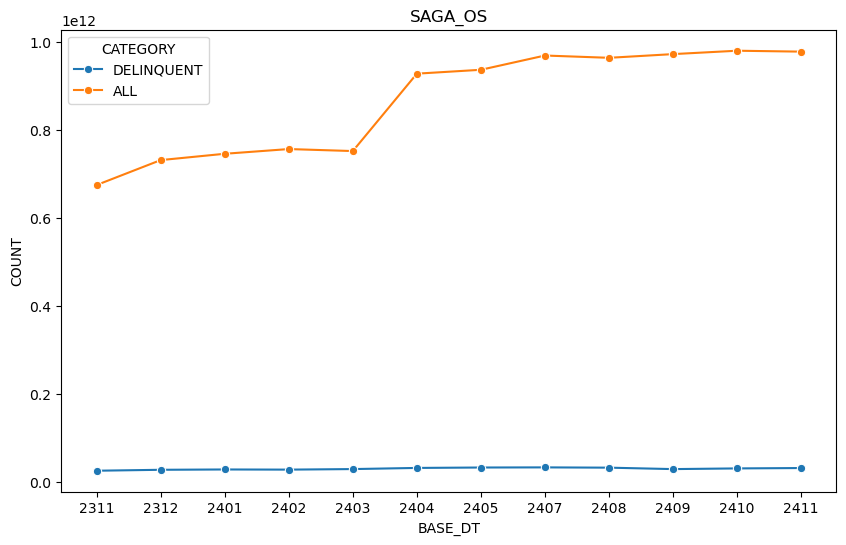

In [25]:
# Plot SAGA count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_OS")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllSAGACount, x="BASE_DT", y='MTD_MAX_OS', hue='CATEGORY', marker="o")

In [26]:
# create wide df to calaculate percentage
AllSagaCountWide = AllSAGACount[AllSAGACount['CATEGORY']=='DELINQUENT'].merge(
    AllSAGACount[AllSAGACount['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [27]:
# save df as csv
AllSAGACount.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\SAGA Total & Delinquent Count.csv')

In [28]:
# fix field names and shi
AllSagaCountWide.columns = ['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'MTD_MAX_OS_DELINQUENT','MICRO_SEGMENT_x', 'CATEGORY_x',
       'ACCT_COUNT_ALL', 'MTD_MAX_OS_ALL', 'MICRO_SEGMENT', 'CATEGORY_y']
AllSagaCountWide = AllSagaCountWide[['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'MTD_MAX_OS_DELINQUENT',
       'ACCT_COUNT_ALL', 'MTD_MAX_OS_ALL', 'MICRO_SEGMENT']]

In [29]:
AllSagaCountWide

,BASE_DT,ACCT_COUNT_DELINQUENT,MTD_MAX_OS_DELINQUENT,ACCT_COUNT_ALL,MTD_MAX_OS_ALL,MICRO_SEGMENT
0,2311,1014,25497160999,117750,674685847615,SAGA
1,2312,999,27613187317,124463,731300754144,SAGA
2,2401,975,28340226675,123028,745666873670,SAGA
3,2402,1011,27995200029,121966,756398168864,SAGA
4,2403,1073,29237991788,121003,751839641246,SAGA
5,2404,1000,31849696650,119507,927713352088,SAGA
6,2405,1025,32786133940,118702,936520220749,SAGA
7,2407,1049,33081562852,117418,968905379109,SAGA
8,2408,960,32447834231,116872,963726920510,SAGA
9,2409,831,29178868152,116010,972134499673,SAGA


In [30]:
# calculate count share
AllSagaCountWide['ACCT_COUNT_SHARE'] = AllSagaCountWide['ACCT_COUNT_DELINQUENT']/AllSagaCountWide['ACCT_COUNT_ALL']

# calculate os share
AllSagaCountWide['OS_SHARE'] = AllSagaCountWide['MTD_MAX_OS_DELINQUENT']/AllSagaCountWide['MTD_MAX_OS_ALL']

In [31]:
# longify for visualization
CountShare = AllSagaCountWide[['BASE_DT','ACCT_COUNT_SHARE']]
CountShare.columns = ['BASE_DT','SHARE']
CountShare['VAR'] = 'COUNT'

OSShare = AllSagaCountWide[['BASE_DT','OS_SHARE']]
OSShare.columns = ['BASE_DT','SHARE']
OSShare['VAR'] = 'OS'

# concat the 2 tables
AllShare = pd.concat([CountShare,OSShare], ignore_index=True)
AllShare['BASE_DT'] = AllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\2811820419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CountShare['VAR'] = 'COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\2811820419.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OSShare['VAR'] = 'OS'


<Axes: title={'center': 'SAGA_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

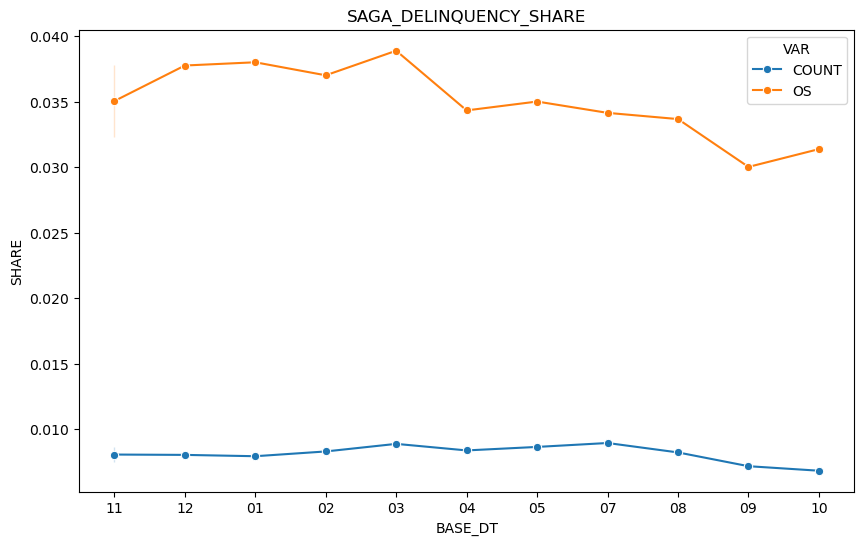

In [32]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("SAGA_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

In [33]:
# save df as csv
AllShare.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\SAGA Delinquency Share.csv')

### c. All Total vs Delinquent

In [34]:
# total deli count (review)
TotalDeliCount

,BASE_DT,ACCT_COUNT,MTD_MAX_OS,MICRO_SEGMENT,CATEGORY
0,20231130,2494,51576027948,ALL,DELINQUENT
1,20231229,2350,51553105072,ALL,DELINQUENT
2,20240131,2242,52224245798,ALL,DELINQUENT
3,20240229,2387,54025926860,ALL,DELINQUENT
4,20240328,2484,57414201653,ALL,DELINQUENT
5,20240430,2303,61705001004,ALL,DELINQUENT
6,20240531,2317,61990248514,ALL,DELINQUENT
7,20240731,2422,63974078306,ALL,DELINQUENT
8,20240829,2353,64356784137,ALL,DELINQUENT
9,20240930,2095,59621858090,ALL,DELINQUENT


In [35]:
# Total aggregate
TotalCount = MLs[[
    'BASE_DT', 'AGREE_ID', 'MTD_MAX_BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          MTD_MAX_OS=('MTD_MAX_BAL','sum')).reset_index()
TotalCount['MICRO_SEGMENT'] = 'ALL'
TotalCount['CATEGORY'] = 'ALL'

In [36]:
# concat tables
AllAll = pd.concat([TotalDeliCount,TotalCount], ignore_index=True)

# format base_dt
AllAll['BASE_DT'] = AllAll['BASE_DT'].str[2:6]

In [37]:
AllAll

,BASE_DT,ACCT_COUNT,MTD_MAX_OS,MICRO_SEGMENT,CATEGORY
0,2311,2494,51576027948,ALL,DELINQUENT
1,2312,2350,51553105072,ALL,DELINQUENT
2,2401,2242,52224245798,ALL,DELINQUENT
3,2402,2387,54025926860,ALL,DELINQUENT
4,2403,2484,57414201653,ALL,DELINQUENT
5,2404,2303,61705001004,ALL,DELINQUENT
6,2405,2317,61990248514,ALL,DELINQUENT
7,2407,2422,63974078306,ALL,DELINQUENT
8,2408,2353,64356784137,ALL,DELINQUENT
9,2409,2095,59621858090,ALL,DELINQUENT


<Axes: title={'center': 'ALL_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

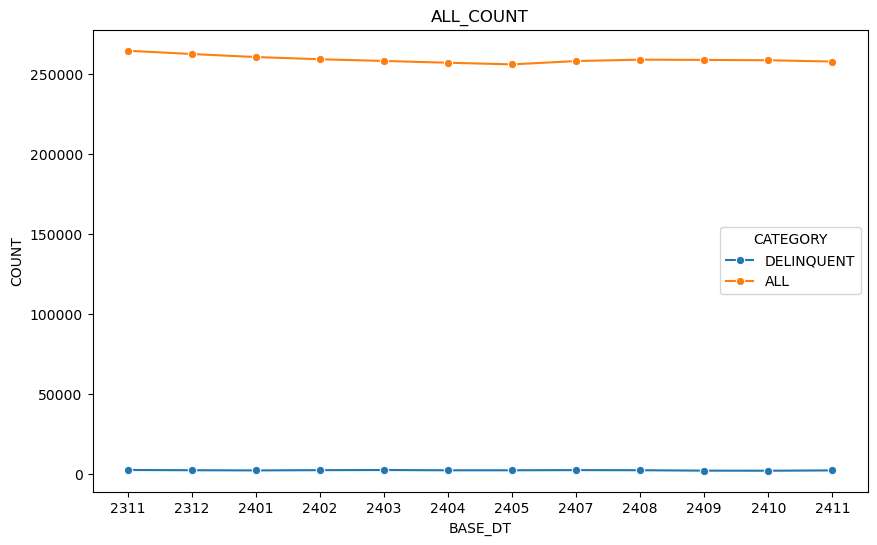

In [38]:
# Plot All count per month
plt.figure(figsize=(10,6))
plt.title("ALL_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllAll, x="BASE_DT", y='ACCT_COUNT', hue='CATEGORY', marker="o")

<Axes: title={'center': 'ALL_OS'}, xlabel='BASE_DT', ylabel='OS'>

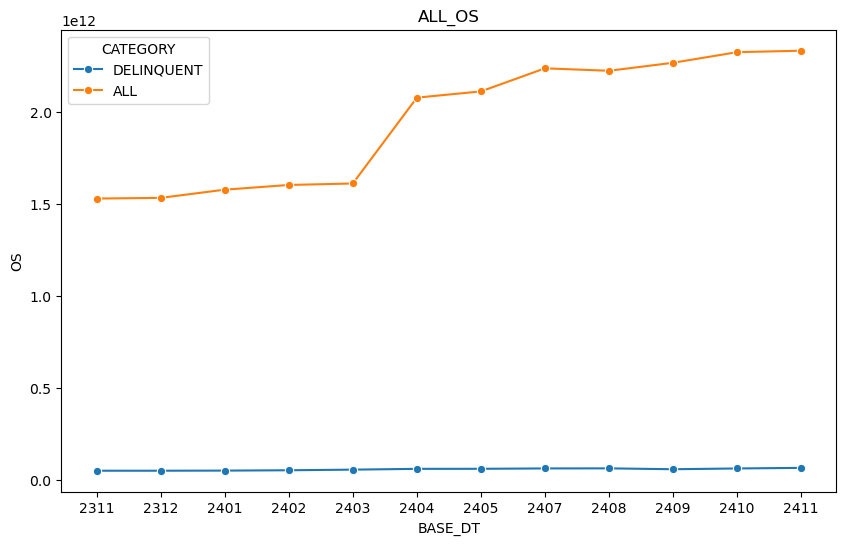

In [39]:
# Plot All count per month
plt.figure(figsize=(10,6))
plt.title("ALL_OS")
plt.xlabel("BASE_DT")
plt.ylabel("OS")
# plt.ylim((0,2000))
sns.lineplot(data=AllAll, x="BASE_DT", y='MTD_MAX_OS', hue='CATEGORY', marker="o")

In [40]:
# save df as csv
AllAll.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\All Total & Delinquency Count.csv')

In [41]:
# create wide df to calaculate percentage
AllCountWide = AllAll[AllAll['CATEGORY']=='DELINQUENT'].merge(
    AllAll[AllAll['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [42]:
# fix field names and shi
AllCountWide.columns = ['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'MTD_MAX_OS_DELINQUENT','MICRO_SEGMENT_x', 'CATEGORY_x',
       'ACCT_COUNT_ALL', 'MTD_MAX_OS_ALL', 'MICRO_SEGMENT', 'CATEGORY_y']
AllCountWide = AllCountWide[['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'MTD_MAX_OS_DELINQUENT',
       'ACCT_COUNT_ALL', 'MTD_MAX_OS_ALL', 'MICRO_SEGMENT']]

In [43]:
# calculate count share
AllCountWide['ACCT_COUNT_SHARE'] = AllCountWide['ACCT_COUNT_DELINQUENT']/AllCountWide['ACCT_COUNT_ALL']

# calculate os share
AllCountWide['OS_SHARE'] = AllCountWide['MTD_MAX_OS_DELINQUENT']/AllCountWide['MTD_MAX_OS_ALL']

In [44]:
# longify for visualization
AllCountShare = AllCountWide[['BASE_DT','ACCT_COUNT_SHARE']]
AllCountShare.columns = ['BASE_DT','SHARE']
AllCountShare['VAR'] = 'COUNT'

AllOSShare = AllCountWide[['BASE_DT','OS_SHARE']]
AllOSShare.columns = ['BASE_DT','SHARE']
AllOSShare['VAR'] = 'OS'

# concat the 2 tables
AllAllShare = pd.concat([AllCountShare,AllOSShare], ignore_index=True)
#AllAllShare['BASE_DT'] = AllAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\1748476280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllCountShare['VAR'] = 'COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\1748476280.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllOSShare['VAR'] = 'OS'


<Axes: title={'center': 'TOTAL_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

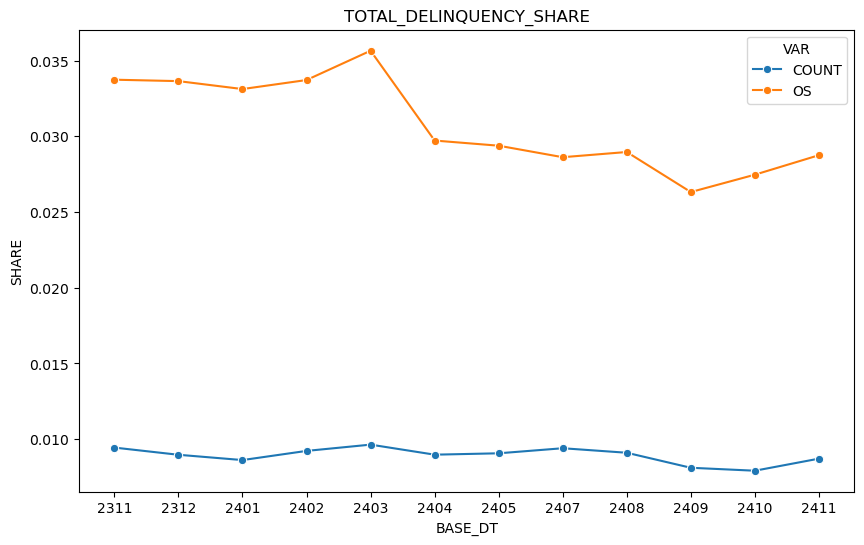

In [45]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("TOTAL_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

In [46]:
# save df as csv
AllAllShare.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\All Delinquency Share.csv')

### d. SAGA Monthly New Delinquent

In [47]:
# set dataframe for dpd change calculation
DPDMonthly = MLs[['BASE_DT', 'AGREE_ID', 'PASTDUE_DAYS']].reset_index(drop=True)

In [48]:
DPDMonthly.drop_duplicates(inplace=True)

In [49]:
# checking pastdue values
DPDMonthly['PASTDUE_DAYS'].value_counts()

PASTDUE_DAYS
0      3037721
1        39806
30       10418
60        6129
90        4368
120       3659
150       3089
210         62
180          7
Name: count, dtype: int64

In [50]:
# create pivot table
DPDMonthlyPivot = DPDMonthly.pivot(index='AGREE_ID',
                                   columns='BASE_DT',
                                   values='PASTDUE_DAYS')

In [51]:
# flaten columns
DPDMonthlyPivot = DPDMonthlyPivot.rename_axis(index=None, columns=None).reset_index()

In [52]:
DPDMonthlyPivot.columns

Index(['index', '20231130', '20231229', '20240131', '20240229', '20240328',
       '20240430', '20240531', '20240731', '20240829', '20240930', '20241031',
       '20241129'],
      dtype='object')

In [53]:
# rename columns
DPDMonthlyPivot.columns = [
    'AGREE_ID', '20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

In [54]:
# fillna with 0
DPDMonthlyPivot.fillna(0, inplace=True)

# date for loop
dateCol = ['20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

# calculate dpd change for all dates
for i in range(1,len(dateCol)):
    prevDate = dateCol[i-1]
    date = dateCol[i]
    DPDMonthlyPivot[f'DELINQUENT_{date}'] = DPDMonthlyPivot.apply(
        lambda x: 1 if x[prevDate]<=30 and x[date]>30 else 0,
        axis=1)

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\3252390541.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DPDMonthlyPivot.fillna(0, inplace=True)


In [55]:
# check value
DPDMonthlyPivot[['DELINQUENT_20240430']].value_counts()

DELINQUENT_20240430
0                      340223
1                         442
Name: count, dtype: int64

In [56]:
# take only used cols
usedCols = [list(DPDMonthlyPivot.columns)[0]]+list(DPDMonthlyPivot.columns)[13:]
DPDMonthlyPivot = DPDMonthlyPivot[usedCols]

In [57]:
# longify
DPDMonthlyLong = pd.wide_to_long(DPDMonthlyPivot,
                                 stubnames='DELINQUENT',
                                 i = 'AGREE_ID',
                                 j = 'BASE_DT',
                                 sep = '_')

In [58]:
# reset index and change base_dt type to string
DPDMonthlyLong = DPDMonthlyLong.reset_index()
DPDMonthlyLong['BASE_DT'] = DPDMonthlyLong['BASE_DT'].astype(str)

In [59]:
DPDMonthlyLong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3747315 entries, 0 to 3747314
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   AGREE_ID    object
 1   BASE_DT     object
 2   DELINQUENT  int64 
dtypes: int64(1), object(2)
memory usage: 85.8+ MB


In [60]:
# merge delinquency flag to original data
MLs = MLs.merge(DPDMonthlyLong[['AGREE_ID', 'BASE_DT', 'DELINQUENT']], on=['AGREE_ID', 'BASE_DT'], how='left')

In [61]:
MLs['DELINQUENT'].value_counts()

DELINQUENT
0.0    2581248
1.0       3732
Name: count, dtype: int64

In [62]:
MLs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3106710 entries, 0 to 3106709
Data columns (total 86 columns):
 #   Column            Dtype         
---  ------            -----         
 0   GCIF_NO           object        
 1   CARD_NMBR         object        
 2   BASE_DT           object        
 3   AGREE_ID          object        
 4   CIF_NO            object        
 5   NOTE_NO           object        
 6   PRD_TP            object        
 7   PRD_NM            object        
 8   PRD_SEGMENT       object        
 9   ORG_LMT_AMT       float64       
 10  CURR_LMT_AMT      float64       
 11  BAL               float64       
 12  ORIG_INT_RT       float64       
 13  CURR_INT_RT       float64       
 14  OTH_CURR_INT_RT   float64       
 15  LAST_RNWL_DT      object        
 16  ORIG_MAT_DT       object        
 17  CURR_MAT_DT       object        
 18  TENOR             object        
 19  DAYS_REMAIN       object        
 20  CLCT_RTNG_FCL     object        
 21  ALLOW_PC

In [63]:
# group data for visualization
monthlyDeli = MLs[(MLs['SAGA_FLAG']=='SAGA') & (MLs['DELINQUENT']==1)][['BASE_DT', 'DELINQUENT', 'MTD_MAX_BAL']].groupby('BASE_DT').agg(ACCT_COUNT=('DELINQUENT','sum'), MTD_MAX_OS=('MTD_MAX_BAL','sum')).reset_index()
monthlyDeliAll = MLs[MLs['DELINQUENT']==1][['BASE_DT', 'DELINQUENT','MTD_MAX_BAL']].groupby('BASE_DT').agg(ACCT_COUNT=('DELINQUENT','sum'), MTD_MAX_OS=('MTD_MAX_BAL','sum')).reset_index()

In [64]:
# flag data
monthlyDeli['MICRO_SEGMENT'] = 'SAGA'
monthlyDeliAll['MICRO_SEGMENT'] = 'ALL'

In [65]:
# combine the data
MonthlyDeliComb = pd.concat([monthlyDeli,monthlyDeliAll], ignore_index=True)

# format data
MonthlyDeliComb['BASE_DT'] = MonthlyDeliComb['BASE_DT'].str[2:6]

# exclude first month because no data of new delinquency
MonthlyDeliComb = MonthlyDeliComb[MonthlyDeliComb['BASE_DT']!='2311']

<Axes: title={'center': 'MONTHLY_DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

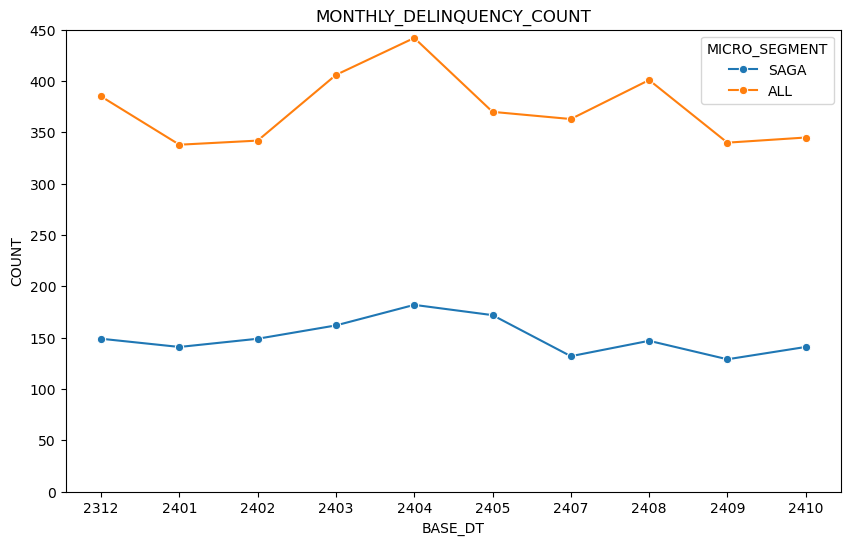

In [66]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylim((0,450))
plt.ylabel("COUNT")
sns.lineplot(data=MonthlyDeliComb, x="BASE_DT", y='ACCT_COUNT', hue='MICRO_SEGMENT', marker="o")

<Axes: title={'center': 'MONTHLY_DELINQUENCY_OS'}, xlabel='BASE_DT', ylabel='OS'>

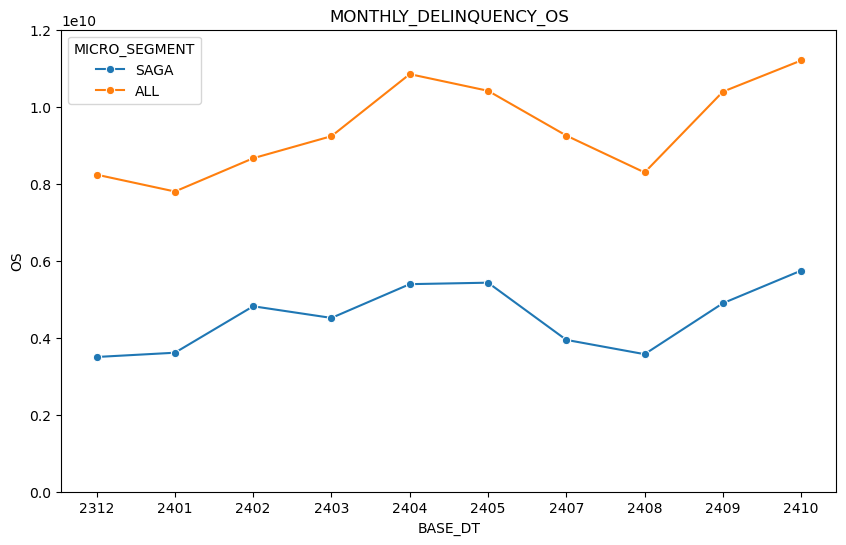

In [67]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_OS")
plt.xlabel("BASE_DT")
plt.ylim((0,12000000000))
plt.ylabel("OS")
sns.lineplot(data=MonthlyDeliComb, x="BASE_DT", y='MTD_MAX_OS', hue='MICRO_SEGMENT', marker="o")

In [68]:
# save df as csv
MonthlyDeliComb.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\Monthly Delinquency Count.csv')

## 2. By GCIF

In [69]:
# create GCIF grouped data
MLsGCIFGPD = MLs[['BASE_DT','GCIF_NO','CURR_LMT_AMT','MTD_MAX_BAL']].groupby(
    ['BASE_DT','GCIF_NO']).agg(
        SUM_LMT=('CURR_LMT_AMT','sum'),
        SUM_BAL=('MTD_MAX_BAL','sum'),
        NOA=('BASE_DT','count')
    ).reset_index()

In [70]:
# create separate df for categorical
MLsGCIFProc = MLs[['BASE_DT','GCIF_NO','SAGA_FLAG','PASTDUE_DAYS']]

In [71]:
# map to integer SAGA flag
SAGAMap = {'SAGA':1,'NON-SAGA':0}
MLsGCIFProc['SAGA_FLAG'] = MLsGCIFProc['SAGA_FLAG'].map(SAGAMap)

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\49022384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLsGCIFProc['SAGA_FLAG'] = MLsGCIFProc['SAGA_FLAG'].map(SAGAMap)


In [72]:
# create categorical GCIF grouped data
MLsGCIFGPD2 = MLsGCIFProc.groupby(
    ['BASE_DT','GCIF_NO']).agg(
        SAGA_FLAG=('SAGA_FLAG','max'),
        PASTDUE_DAYS_MAX=('PASTDUE_DAYS','max'),
).reset_index()

In [73]:
MLsGCIFGPD.duplicated(subset=['BASE_DT','GCIF_NO']).sum()

0

In [74]:
MLsGCIFGPD2.duplicated(subset=['BASE_DT','GCIF_NO']).sum()

0

In [75]:
# merge the numeric and categorical data
MLsGCIF = MLsGCIFGPD.merge(MLsGCIFGPD2, on=['BASE_DT','GCIF_NO'], how='left')

In [76]:
# map data
MLsGCIF['SAGA_FLAG'] = MLsGCIF['SAGA_FLAG'].map({1:'SAGA',0:'NON-SAGA'})
MLsGCIF['CC_STATUS'] = MLsGCIF.apply(
    lambda x: 'DELINQUENT' if x['PASTDUE_DAYS_MAX']>30 else 'PERFORMING' if x['PASTDUE_DAYS_MAX']==0 else 'GRACE_PERIOD',
    axis=1)

In [77]:
MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'][['PASTDUE_DAYS_MAX','CC_STATUS']].value_counts()

PASTDUE_DAYS_MAX  CC_STATUS   
0                 PERFORMING      708790
1                 GRACE_PERIOD     15131
30                GRACE_PERIOD      3884
60                DELINQUENT        2097
90                DELINQUENT        1479
120               DELINQUENT        1300
150               DELINQUENT        1129
210               DELINQUENT          31
Name: count, dtype: int64

In [78]:
MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'][['PASTDUE_DAYS_MAX','CC_STATUS']].value_counts()

PASTDUE_DAYS_MAX  CC_STATUS   
0                 PERFORMING      708790
1                 GRACE_PERIOD     15131
30                GRACE_PERIOD      3884
60                DELINQUENT        2097
90                DELINQUENT        1479
120               DELINQUENT        1300
150               DELINQUENT        1129
210               DELINQUENT          31
Name: count, dtype: int64

In [79]:
# Total all GCIF aggregate
TotalGCIFCount = MLsGCIF.groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
TotalGCIFCount['MICRO_SEGMENT'] = 'ALL'
TotalGCIFCount['CATEGORY'] = 'ALL'

In [80]:
TotalGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,149762,4.906867e+12,1528436798555,264245,ALL,ALL
1,20231229,149067,4.937573e+12,1532027869616,262186,ALL,ALL
2,20240131,148872,5.043792e+12,1576537733008,260296,ALL,ALL
3,20240229,148754,5.117726e+12,1602076843386,258925,ALL,ALL
4,20240328,148282,5.122307e+12,1610100298382,257851,ALL,ALL
5,20240430,148537,5.209868e+12,2075924032905,256748,ALL,ALL
6,20240531,148548,5.273967e+12,2109694797530,255724,ALL,ALL
7,20240731,149707,5.771166e+12,2235031334177,257792,ALL,ALL
8,20240829,150247,5.815171e+12,2221726755136,258666,ALL,ALL
9,20240930,151174,5.833236e+12,2265178061649,258495,ALL,ALL


In [81]:
# Total delinquent GCIF aggregate
TotalDeliGCIFCount = MLsGCIF[MLsGCIF['CC_STATUS']=='DELINQUENT'].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
TotalDeliGCIFCount['MICRO_SEGMENT'] = 'ALL'
TotalDeliGCIFCount['CATEGORY'] = 'DELINQUENT'

In [82]:
TotalDeliGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,1366,3.767314e+10,36121155015,1904,ALL,DELINQUENT
1,20231229,1324,3.862607e+10,36498756011,1826,ALL,DELINQUENT
2,20240131,1270,3.922884e+10,36853438906,1750,ALL,DELINQUENT
3,20240229,1249,4.018425e+10,37558646885,1691,ALL,DELINQUENT
4,20240328,1281,4.332514e+10,39764497922,1787,ALL,DELINQUENT
5,20240430,1309,4.826418e+10,44083271501,1857,ALL,DELINQUENT
6,20240531,1257,4.936701e+10,47137350496,1802,ALL,DELINQUENT
7,20240731,1306,5.330899e+10,47973621190,1943,ALL,DELINQUENT
8,20240829,1211,4.727194e+10,44996267872,1712,ALL,DELINQUENT
9,20240930,1190,4.484225e+10,41121051561,1644,ALL,DELINQUENT


In [83]:
# Total SAGA GCIF aggregate
SAGAGCIFCount = MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
SAGAGCIFCount['MICRO_SEGMENT'] = 'SAGA'
SAGAGCIFCount['CATEGORY'] = 'ALL'

In [84]:
# Total SAGA delinquent GCIF aggregate
SAGADeliGCIFCount = MLsGCIF[(MLsGCIF['SAGA_FLAG']=='SAGA')&(MLsGCIF['CC_STATUS']=='DELINQUENT')].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
SAGADeliGCIFCount['MICRO_SEGMENT'] = 'SAGA'
SAGADeliGCIFCount['CATEGORY'] = 'DELINQUENT'

In [85]:
TotalGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,149762,4.906867e+12,1528436798555,264245,ALL,ALL
1,20231229,149067,4.937573e+12,1532027869616,262186,ALL,ALL
2,20240131,148872,5.043792e+12,1576537733008,260296,ALL,ALL
3,20240229,148754,5.117726e+12,1602076843386,258925,ALL,ALL
4,20240328,148282,5.122307e+12,1610100298382,257851,ALL,ALL
5,20240430,148537,5.209868e+12,2075924032905,256748,ALL,ALL
6,20240531,148548,5.273967e+12,2109694797530,255724,ALL,ALL
7,20240731,149707,5.771166e+12,2235031334177,257792,ALL,ALL
8,20240829,150247,5.815171e+12,2221726755136,258666,ALL,ALL
9,20240930,151174,5.833236e+12,2265178061649,258495,ALL,ALL


### a. SAGA vs ALL Delinquency

<Axes: title={'center': 'DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

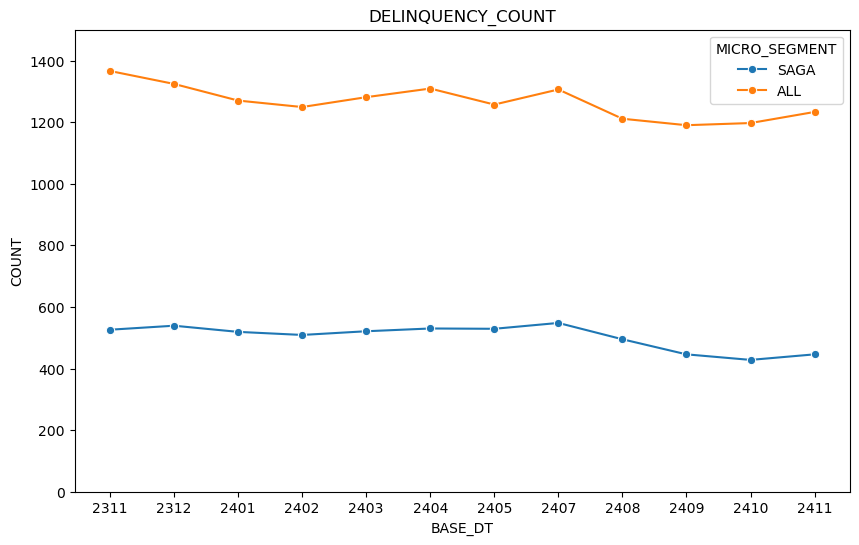

In [86]:
# concat data
GCIFPlot1 = pd.concat([SAGADeliGCIFCount,TotalDeliGCIFCount])
GCIFPlot1['BASE_DT'] = GCIFPlot1['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
plt.ylim((0,1500))
sns.lineplot(data=GCIFPlot1, x="BASE_DT", y='CUST_NUM', hue='MICRO_SEGMENT', marker="o")

In [87]:
# save df as csv
GCIFPlot1.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\GCIF Total & Delinquency Count.csv')

### b. SAGA Total vs Delinquency

<Axes: title={'center': 'SAGA_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

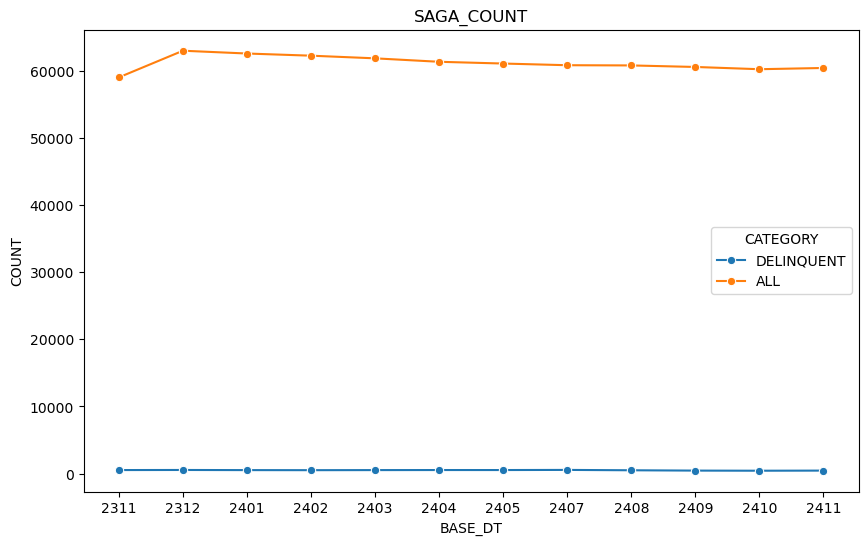

In [88]:
# concat data
GCIFPlot2 = pd.concat([SAGADeliGCIFCount,SAGAGCIFCount])
GCIFPlot2['BASE_DT'] = GCIFPlot2['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
#plt.ylim((0,2300))
sns.lineplot(data=GCIFPlot2, x="BASE_DT", y='CUST_NUM', hue='CATEGORY', marker="o")

In [89]:
# save df as csv
GCIFPlot2.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\GCIF SAGA Total & Delinquency Count.csv')

In [90]:
GCIFPlot2

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,2311,526,1.899306e+10,18030030281,801,SAGA,DELINQUENT
1,2312,539,2.044668e+10,19167948728,800,SAGA,DELINQUENT
2,2401,519,2.089524e+10,19430462234,750,SAGA,DELINQUENT
3,2402,509,2.110677e+10,19343707362,720,SAGA,DELINQUENT
4,2403,521,2.253835e+10,20077702206,809,SAGA,DELINQUENT
5,2404,530,2.500753e+10,22422190193,832,SAGA,DELINQUENT
6,2405,529,2.686436e+10,25126374733,855,SAGA,DELINQUENT
7,2407,548,2.823189e+10,25274153189,899,SAGA,DELINQUENT
8,2408,495,2.398844e+10,23062971556,744,SAGA,DELINQUENT
9,2409,446,2.161660e+10,19519769026,649,SAGA,DELINQUENT


In [91]:
# create wide df to calaculate percentage
GCIFPlot2Wide = GCIFPlot2[GCIFPlot2['CATEGORY']=='DELINQUENT'].merge(
    GCIFPlot2[GCIFPlot2['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [92]:
GCIFPlot2Wide.columns

Index(['BASE_DT', 'CUST_NUM_x', 'TOTAL_LMT_x', 'TOTAL_BAL_x', 'TOTAL_NOA_x',
       'MICRO_SEGMENT_x', 'CATEGORY_x', 'CUST_NUM_y', 'TOTAL_LMT_y',
       'TOTAL_BAL_y', 'TOTAL_NOA_y', 'MICRO_SEGMENT_y', 'CATEGORY_y'],
      dtype='object')

In [93]:
# fix field names and shi
GCIFPlot2Wide.columns = ['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT', 'MICRO_SEGMENT_x',
                            'CATEGORY_x', 'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT', 'CATEGORY_y']
GCIFPlot2Wide = GCIFPlot2Wide[['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT',
                            'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT']]

In [94]:
# calculate count share
GCIFPlot2Wide['CUST_NUM_SHARE'] = GCIFPlot2Wide['CUST_NUM_DELINQUENT']/GCIFPlot2Wide['CUST_NUM_ALL']

# calculate os share
GCIFPlot2Wide['OS_SHARE'] = GCIFPlot2Wide['TOTAL_BAL_DELINQUENT']/GCIFPlot2Wide['TOTAL_BAL_ALL']

In [95]:
# longify for visualization
GCIFCountShare = GCIFPlot2Wide[['BASE_DT','CUST_NUM_SHARE']]
GCIFCountShare.columns = ['BASE_DT','SHARE']
GCIFCountShare['VAR'] = 'GCIF_COUNT'

GCIFOSShare = GCIFPlot2Wide[['BASE_DT','OS_SHARE']]
GCIFOSShare.columns = ['BASE_DT','SHARE']
GCIFOSShare['VAR'] = 'OS'

# concat the 2 tables
GCIFAllShare = pd.concat([GCIFCountShare,GCIFOSShare], ignore_index=True)
GCIFAllShare['BASE_DT'] = GCIFAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\2687063092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GCIFCountShare['VAR'] = 'GCIF_COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\2687063092.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GCIFOSShare['VAR'] = 'OS'


<Axes: title={'center': 'SAGA_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

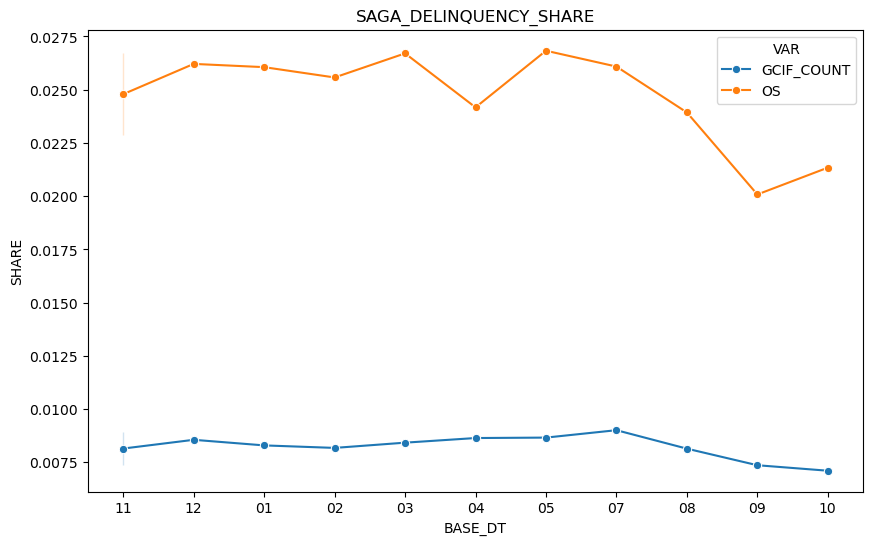

In [96]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("SAGA_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=GCIFAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

In [97]:
# save df as csv
GCIFAllShare.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\GCIF SAGA Delinquency Count.csv')

### c. All Total vs Delinquent

<Axes: title={'center': 'ALL_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

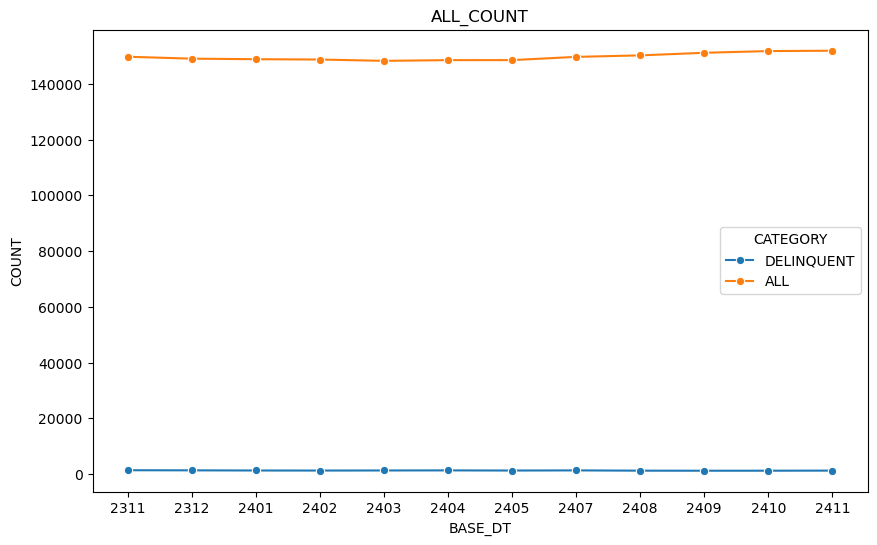

In [98]:
# concat data
GCIFPlot3 = pd.concat([TotalDeliGCIFCount,TotalGCIFCount])
GCIFPlot3['BASE_DT'] = GCIFPlot3['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("ALL_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
#plt.ylim((0,2300))
sns.lineplot(data=GCIFPlot3, x="BASE_DT", y='CUST_NUM', hue='CATEGORY', marker="o")

In [99]:
GCIFPlot3

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,2311,1366,3.767314e+10,36121155015,1904,ALL,DELINQUENT
1,2312,1324,3.862607e+10,36498756011,1826,ALL,DELINQUENT
2,2401,1270,3.922884e+10,36853438906,1750,ALL,DELINQUENT
3,2402,1249,4.018425e+10,37558646885,1691,ALL,DELINQUENT
4,2403,1281,4.332514e+10,39764497922,1787,ALL,DELINQUENT
5,2404,1309,4.826418e+10,44083271501,1857,ALL,DELINQUENT
6,2405,1257,4.936701e+10,47137350496,1802,ALL,DELINQUENT
7,2407,1306,5.330899e+10,47973621190,1943,ALL,DELINQUENT
8,2408,1211,4.727194e+10,44996267872,1712,ALL,DELINQUENT
9,2409,1190,4.484225e+10,41121051561,1644,ALL,DELINQUENT


In [100]:
# save df as csv
GCIFPlot3.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\GCIF All Total & Delinquency Count.csv')

In [101]:
# create wide df to calaculate percentage
GCIFPlot3Wide = GCIFPlot3[GCIFPlot3['CATEGORY']=='DELINQUENT'].merge(
    GCIFPlot3[GCIFPlot3['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [102]:
# fix field names and shi
GCIFPlot3Wide.columns = ['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT', 'MICRO_SEGMENT_x',
                            'CATEGORY_x', 'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT', 'CATEGORY_y']
GCIFPlot3Wide = GCIFPlot3Wide[['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT',
                            'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT']]

In [103]:
# calculate count share
GCIFPlot3Wide['CUST_NUM_SHARE'] = GCIFPlot3Wide['CUST_NUM_DELINQUENT']/GCIFPlot3Wide['CUST_NUM_ALL']

# calculate os share
GCIFPlot3Wide['OS_SHARE'] = GCIFPlot3Wide['TOTAL_BAL_DELINQUENT']/GCIFPlot3Wide['TOTAL_BAL_ALL']

In [104]:
# longify for visualization
AllGCIFCountShare = GCIFPlot3Wide[['BASE_DT','CUST_NUM_SHARE']]
AllGCIFCountShare.columns = ['BASE_DT','SHARE']
AllGCIFCountShare['VAR'] = 'GCIF_COUNT'

AllGCIFOSShare = GCIFPlot3Wide[['BASE_DT','OS_SHARE']]
AllGCIFOSShare.columns = ['BASE_DT','SHARE']
AllGCIFOSShare['VAR'] = 'OS'

# concat the 2 tables
AllGCIFAllShare = pd.concat([AllGCIFCountShare,AllGCIFOSShare], ignore_index=True)
AllGCIFAllShare['BASE_DT'] = AllGCIFAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\3087575407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllGCIFCountShare['VAR'] = 'GCIF_COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\3087575407.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllGCIFOSShare['VAR'] = 'OS'


<Axes: title={'center': 'ALL_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

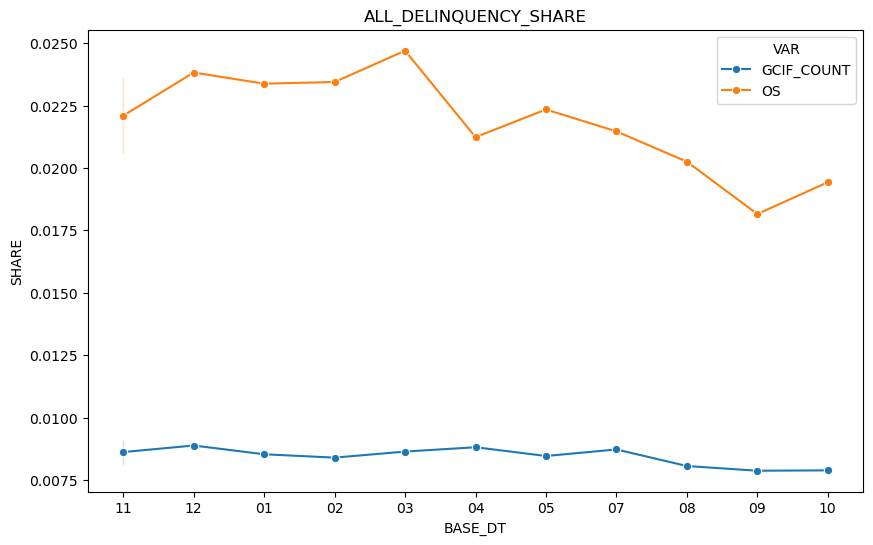

In [105]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("ALL_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllGCIFAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

In [106]:
# save df as csv
AllGCIFAllShare.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\GCIF All Delinquency Share.csv')

### d. SAGA Monthly New Delinquent

In [107]:
# set dataframe for dpd change calculation
DPDMonthlyGCIF = MLsGCIF[['BASE_DT', 'GCIF_NO', 'PASTDUE_DAYS_MAX']].reset_index()

In [108]:
# create pivot table
DPDMonthlyGCIFPivot = DPDMonthlyGCIF.pivot(index='GCIF_NO',
                                   columns='BASE_DT',
                                   values='PASTDUE_DAYS_MAX')

In [109]:
# flaten columns
DPDMonthlyGCIFPivot = DPDMonthlyGCIFPivot.rename_axis(index=None, columns=None).reset_index()

In [110]:
DPDMonthlyGCIFPivot.columns

Index(['index', '20231130', '20231229', '20240131', '20240229', '20240328',
       '20240430', '20240531', '20240731', '20240829', '20240930', '20241031',
       '20241129'],
      dtype='object')

In [111]:
# rename columns
DPDMonthlyGCIFPivot.columns = [
    'GCIF_NO', '20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

In [112]:
# fillna with 0
DPDMonthlyGCIFPivot.fillna(0, inplace=True)

# date for loop
dateCol = ['20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

# calculate dpd change for all dates
for i in range(1,len(dateCol)):
    prevDate = dateCol[i-1]
    date = dateCol[i]
    DPDMonthlyGCIFPivot[f'DELINQUENT_{date}'] = DPDMonthlyGCIFPivot.apply(
        lambda x: 1 if x[prevDate]<30 and x[date]>=30 else 0,
        axis=1)

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\720622738.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DPDMonthlyGCIFPivot.fillna(0, inplace=True)


In [113]:
# check value
DPDMonthlyGCIFPivot[['DELINQUENT_20240430']].value_counts()

DELINQUENT_20240430
0                      174140
1                         496
Name: count, dtype: int64

In [114]:
# take only used cols
usedCols = [list(DPDMonthlyGCIFPivot.columns)[0]]+list(DPDMonthlyGCIFPivot.columns)[13:]
DPDMonthlyGCIFPivot = DPDMonthlyGCIFPivot[usedCols]

In [115]:
# longify
DPDMonthlyGCIFLong = pd.wide_to_long(DPDMonthlyGCIFPivot,
                                 stubnames='DELINQUENT',
                                 i = 'GCIF_NO',
                                 j = 'BASE_DT',
                                 sep = '_')

In [116]:
# reset index and change base_dt type to string
DPDMonthlyGCIFLong = DPDMonthlyGCIFLong.reset_index()
DPDMonthlyGCIFLong['BASE_DT'] = DPDMonthlyGCIFLong['BASE_DT'].astype(str)

In [117]:
DPDMonthlyGCIFLong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920996 entries, 0 to 1920995
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   GCIF_NO     object
 1   BASE_DT     object
 2   DELINQUENT  int64 
dtypes: int64(1), object(2)
memory usage: 44.0+ MB


In [118]:
# merge delinquency flag to original data
MLsGCIF = MLsGCIF.merge(DPDMonthlyGCIFLong[['GCIF_NO', 'BASE_DT', 'DELINQUENT']], on=['GCIF_NO', 'BASE_DT'], how='left')

In [119]:
MLsGCIF['DELINQUENT'].value_counts()

DELINQUENT
0.0    1489501
1.0       5479
Name: count, dtype: int64

In [120]:
# group data for visualization
monthlyGCIFDeli = MLsGCIF[(MLsGCIF['SAGA_FLAG']=='SAGA') & (MLsGCIF['DELINQUENT']==1)][['BASE_DT', 'DELINQUENT', 'SUM_BAL']].groupby('BASE_DT').agg(GCIF_COUNT=('DELINQUENT','sum'), OS=('SUM_BAL','sum')).reset_index()
monthlyGCIFDeliAll = MLsGCIF[MLsGCIF['DELINQUENT']==1][['BASE_DT', 'DELINQUENT','SUM_BAL']].groupby('BASE_DT').agg(GCIF_COUNT=('DELINQUENT','sum'), OS=('SUM_BAL','sum')).reset_index()

In [121]:
# flag data
monthlyGCIFDeli['MICRO_SEGMENT'] = 'SAGA'
monthlyGCIFDeliAll['MICRO_SEGMENT'] = 'ALL'

In [122]:
# combine the data
MonthlyGCIFDeliComb = pd.concat([monthlyGCIFDeli,monthlyGCIFDeliAll], ignore_index=True)

# format data
MonthlyGCIFDeliComb['BASE_DT'] = MonthlyGCIFDeliComb['BASE_DT'].str[2:6]

# exclude first month because no data of new delinquency
MonthlyGCIFDeliComb = MonthlyGCIFDeliComb[MonthlyDeliComb['BASE_DT']!='2311']

<Axes: title={'center': 'MONTHLY_DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

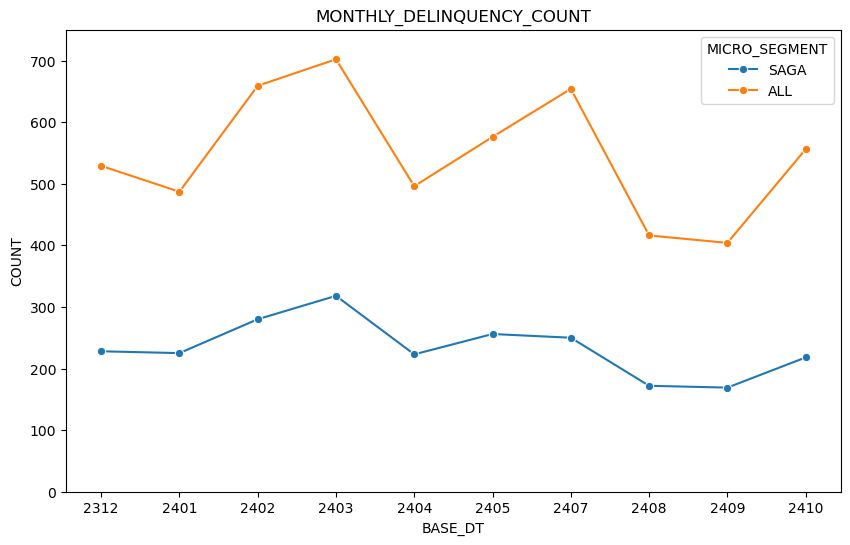

In [123]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylim((0,750))
plt.ylabel("COUNT")
sns.lineplot(data=MonthlyGCIFDeliComb, x="BASE_DT", y='GCIF_COUNT', hue='MICRO_SEGMENT', marker="o")

In [124]:
# save AllDelicount as csv
MonthlyGCIFDeliComb.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\GCIF Monthly Delinquency Share.csv')

## 3. Distribution

In [125]:
MLs

,GCIF_NO,CARD_NMBR,BASE_DT,AGREE_ID,CIF_NO,NOTE_NO,PRD_TP,PRD_NM,PRD_SEGMENT,ORG_LMT_AMT,CURR_LMT_AMT,BAL,ORIG_INT_RT,CURR_INT_RT,OTH_CURR_INT_RT,LAST_RNWL_DT,ORIG_MAT_DT,CURR_MAT_DT,TENOR,DAYS_REMAIN,CLCT_RTNG_FCL,ALLOW_PCT,ALLOW_PCT_ADD,RESTRUCT_CD,PASTDUE_SINCE_DT,PASTDUE_DAYS,WRITE_OFF_AMT,WRITE_OFF_DT,WRITE_OFF_YN,CC_STATUS,SEGMENT,CUST_NM,OPEN_DATE,LAST_ACTIVE_DATE,CUST_TP,GENDER_CD,AGE,SAGA_FLAG,EMPLOYMENT_TYPE,CA_BAL,CA_AVG,SA_BAL,SA_AVG,TD_NOA,TD_BAL,TD_AVG,SY_FUNDING_BAL,SY_FUNDING_AVG,FUNDING_NOA,FUNDING_BAL,FUNDING_AVG,NOA_DORMANT,CC_PLAFOND,CC_BAL,PL_PLAFOND,PLOAN_BAL,TR_PLAFOND,TR_BAL,PB_PLAFOND,PB_BAL,PRK_PLAFOND,PRK_BAL,PPB_PLAFOND,PPB_BAL,BG_PLAFOND,BG_BAL,LC_PLAFOND,LC_BAL,SY_LOAN_PLAFOND,SY_LOAN_BAL,KPR_PLAFOND,KPR_BAL,KPM_PLAFOND,KPM_BAL,COLLECT,MF_BAL,BONDS_BAL,TRB,M2U_TRX_TOTAL,M2U_TRXAMT_FIN,CRTRX_MTD,CRTRX_AMT_MTD,DBTRX_MTD,DBTRX_AMT_MTD,MTD_MAX_BAL,DELINQUENT
0,G800057283,4423730018529001,20241129,CP0010014423730018529001,1010001100691231,4423730018529001,001,Credit Card,031100,4000000.0,10000000.0,6000.0,0.21,0.21,0.21,19980319,20050531,20100531,4456,-5296,00001,0.01,0.0,00008,99991231,0,0.0,None,N,PERFORMING,None,SAMSURI,1995-06-09 00:00:00,NaT,INDV,M,57.0,SAGA,OTHERS,0.0,0.0,0.0,0.000000e+00,0,0.0,0.0,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.0,0.0,6.000000e+03,0,0.0,0,0.0,0,0.0,6000,NaN
1,G300377330,4423730022935020,20241129,CP0010014423730022935020,1030500000059551,4423730022935020,001,Credit Card,031100,4200000.0,11000000.0,759537.0,0.21,0.21,0.21,20240508,20240630,20290630,1879,1674,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,"DEWI SOELISTYORINIE, SH",1996-07-15 00:00:00,NaT,INDV,F,65.0,SAGA,OTHERS,0.0,0.0,0.0,0.000000e+00,0,0.0,0.0,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,4200000.0,759537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.0,0.0,7.595370e+05,0,0.0,0,0.0,0,0.0,834537,NaN
2,G300038494,4423730185378018,20241129,CP0010014423730185378018,1010001100418254,4423730185378018,001,Credit Card,031100,5000000.0,6000000.0,0.0,0.21,0.21,0.21,20130507,20130630,20180630,1880,-2344,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,VONNYWATI S,2008-06-12 00:00:00,NaT,INDV,F,59.0,SAGA,OTHERS,0.0,0.0,0.0,0.000000e+00,0,0.0,0.0,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,5000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.0,0.0,0.000000e+00,0,0.0,0,0.0,0,0.0,0,NaN
3,G103569067,4423740083618100,20241129,CP0010024423740083618100,1010041650001746,4423740083618100,001,Credit Card,031100,6000000.0,2436747.5,0.0,0.21,0.21,0.21,20220509,20220630,20270630,1878,943,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,TENDY,2009-05-18 00:00:00,NaT,INDV,M,41.0,NON-SAGA,OTHERS,0.0,0.0,0.0,0.000000e+00,0,0.0,0.0,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,7000000.0,5126505.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.0,0.0,5.126505e+06,0,0.0,0,0.0,0,0.0,0,NaN
4,G008795635,4423740006060000,20241129,CP0010024423740006060000,1010001100181852,4423740006060000,001,Credit Card,031100,15000000.0,13317500.0,0.0,0.21,0.21,0.21,19971112,00010131,20000630,961,-8918,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,CFS-RB-5MB,LIVIA MALINDA,1990-06-22 00:00:00,NaT,INDV,F,76.0,SAGA,HOUSEWIFE,0.0,0.0,0.0,0.000000e+00,0,0.0,0.0,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,40000000.0,47500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.0,0.0,4.750000e+04,0,0.0,0,0.0,0,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

### a. BAL by SAGA_FLAG and CC_STATUS

c:\Users\MR38804\AppData\Local\anaconda3\envs\Py64\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<Axes: xlabel='SAGA_FLAG', ylabel='MTD_MAX_BAL'>

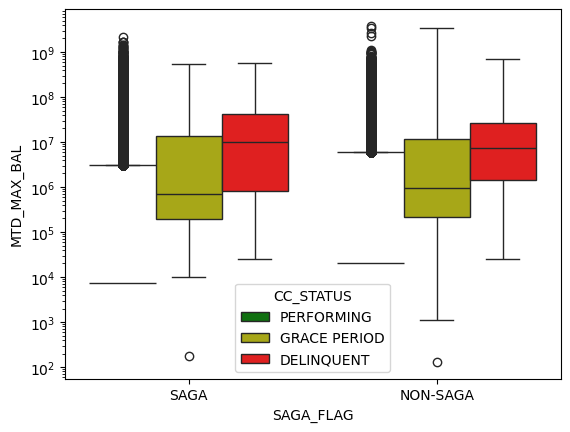

In [126]:
# create BAL boxplot by SAGA FLAG
sns.boxplot(data=MLs, x="SAGA_FLAG", y="MTD_MAX_BAL", hue="CC_STATUS", log_scale=True,
            palette={'PERFORMING':'g','GRACE PERIOD':'y','DELINQUENT':'r'})

### b. LMT by SAGA_FLAG and CC_STATUS

<Axes: xlabel='SAGA_FLAG', ylabel='CURR_LMT_AMT'>

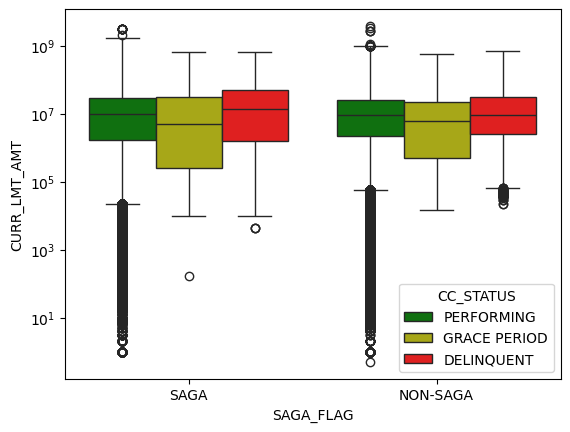

In [127]:
# create LMT boxplot by SAGA FLAG
sns.boxplot(data=MLs, x="SAGA_FLAG", y="CURR_LMT_AMT", hue="CC_STATUS", log_scale=True,
            palette={'PERFORMING':'g','GRACE PERIOD':'y','DELINQUENT':'r'})

### c. Monthly Delinquentts by SAGA_FLAG and CC_STATUS

In [194]:
MLs['BASE_YM'] = MLs['BASE_DT'].str[2:6]

<Axes: xlabel='BASE_YM', ylabel='MTD_MAX_BAL'>

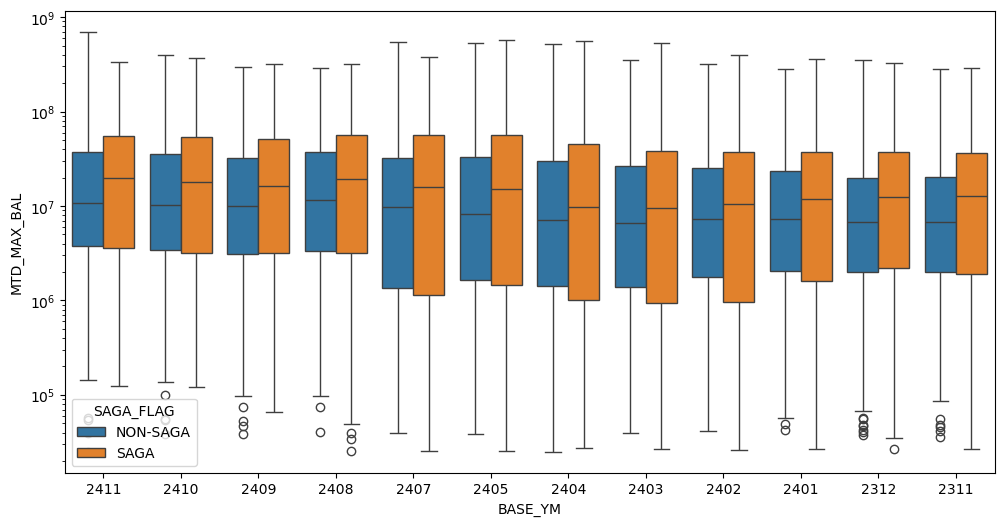

In [195]:
# create boxplot MONTHLY
plt.figure(figsize=(12,6))
sns.boxplot(data=MLs[MLs['CC_STATUS']=='DELINQUENT'], x="BASE_YM", y="MTD_MAX_BAL", hue="SAGA_FLAG", log_scale=True)

<Axes: xlabel='BASE_YM', ylabel='CURR_LMT_AMT'>

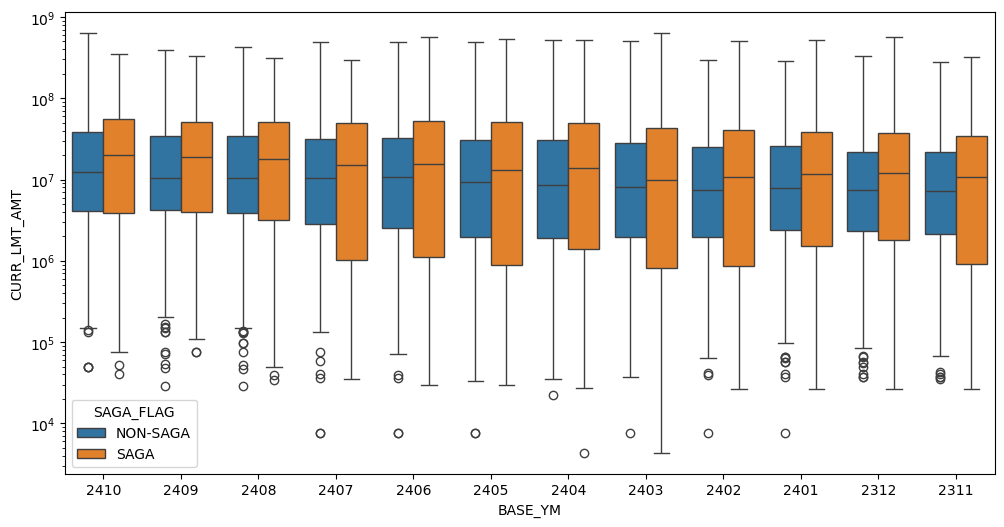

In [183]:
# create boxplot MONTHLY
plt.figure(figsize=(12,6))
sns.boxplot(data=MLs[MLs['CC_STATUS']=='DELINQUENT'], x="BASE_YM", y="CURR_LMT_AMT", hue="SAGA_FLAG", log_scale=True)

### d. Utilization

In [128]:
# calculate utilization
MLs['UTIL'] = MLs.apply(lambda x: x['MTD_MAX_BAL']/x['CURR_LMT_AMT'] if x['CURR_LMT_AMT']>0 else 0, axis=1)

<Axes: xlabel='BASE_DT', ylabel='UTIL'>

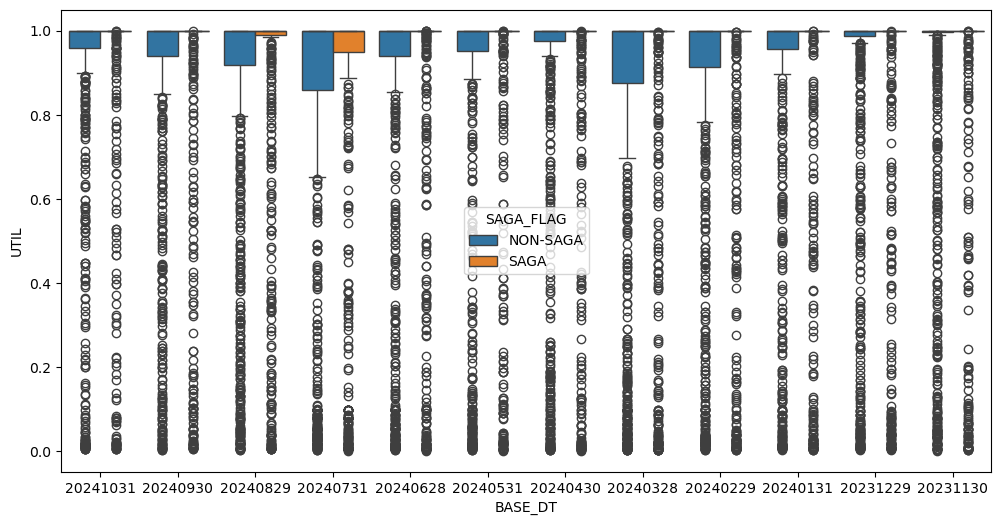

In [122]:
# create boxplot MONTHLY
plt.figure(figsize=(12,6))
sns.boxplot(data=MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['UTIL']<=1)], x="BASE_DT", y="UTIL", hue="SAGA_FLAG")

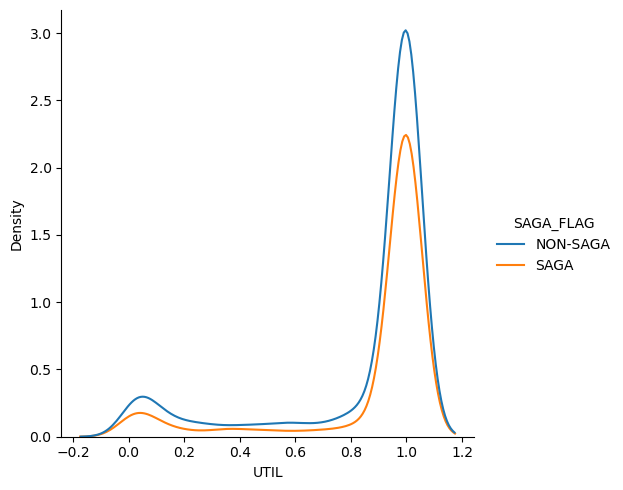

In [125]:
# # plot utilizatiuon kde for delinquents by SAGA_FLAG
# sns.displot(MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['UTIL']<=1)], x='UTIL', hue='SAGA_FLAG', kind='kde')

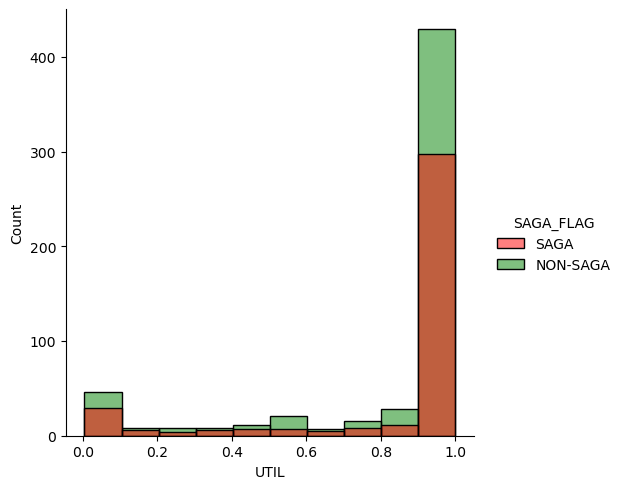

In [134]:
# plot utilizatiuon histogram for delinquents by SAGA_FLAG
sns.displot(MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['UTIL']<=1) & (MLs['BASE_DT']=='20241031')].sort_values('SAGA_FLAG', ascending=False), x='UTIL', hue='SAGA_FLAG', binwidth=0.1,
            palette={'SAGA':'r','NON-SAGA':'g'})

In [ ]:
# # plot utilizatiuon kde for performers by SAGA_FLAG
# sns.displot(MLs[(MLs['CC_STATUS']=='PERFORMING') & (MLs['UTIL']<=1)], x='UTIL', hue='SAGA_FLAG', kind='kde')

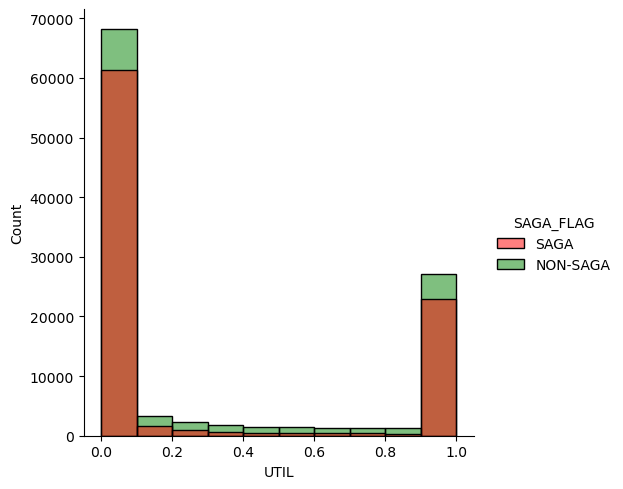

In [136]:
# plot utilizatiuon histogram for performers by SAGA_FLAG
sns.displot(MLs[(MLs['UTIL']<=1) & (MLs['BASE_DT']=='20241031')].sort_values('SAGA_FLAG', ascending=False), x='UTIL', hue='SAGA_FLAG', binwidth=0.1,
            palette={'SAGA':'r','NON-SAGA':'g'})

In [160]:
np.histogram(MLs[(MLs['UTIL']<=1) & (MLs['BASE_DT']=='20241031')&(MLs['SAGA_FLAG']=='SAGA')]['UTIL'], bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

(array([61314,  1606,  1006,   711,   539,   469,   395,   400,   357,
        22934], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [162]:
np.histogram(MLs[(MLs['UTIL']<=1) & (MLs['BASE_DT']=='20241031')&(MLs['SAGA_FLAG']=='NON-SAGA')]['UTIL'], bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

(array([68151,  3364,  2355,  1754,  1464,  1391,  1217,  1254,  1360,
        27075], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

### e. Employment Type

In [137]:
MLsGCIF

,BASE_DT,GCIF_NO,SUM_LMT,SUM_BAL,NOA,SAGA_FLAG,PASTDUE_DAYS_MAX,CC_STATUS,DELINQUENT
0,20231130,G000000828,10009000.0,18000,3,SAGA,0,PERFORMING,NaN
1,20231130,G000001594,21510526.0,21510526,2,SAGA,0,PERFORMING,NaN
2,20231130,G000001669,41391925.0,41391925,1,SAGA,0,PERFORMING,NaN
3,20231130,G000002071,21840257.0,21840257,2,SAGA,0,PERFORMING,NaN
4,20231130,G000002113,50295309.0,50295309,1,SAGA,0,PERFORMING,NaN
...,...,...,...,...,...,...,...,...,...
1796654,20241129,G910437060,25000000.0,0,1,NON-SAGA,0,PERFORMING,NaN
1796655,20241129,G910437458,50000000.0,0,1,NON-SAGA,0,PERFORMING,NaN
1796656,20241129,G910439629,41000000.0,0,1,NON-SAGA,0,PERFORMING,NaN
1796657,20241129,G910439645,15000000.0,0,1,NON-SAGA,0,PERFORMING,NaN


In [138]:
# distinct base_dt emp_type df
distEmp = MLs[['BASE_DT','GCIF_NO','EMPLOYMENT_TYPE']].drop_duplicates()


In [139]:
# merge employment type
MLsGCIFEmp = MLsGCIF.merge(distEmp, on=['BASE_DT','GCIF_NO'], how='left')

# group based on employment type
EmpGPD = MLsGCIFEmp[['BASE_DT','SUM_LMT','SUM_BAL','NOA',
                  'SAGA_FLAG','CC_STATUS','EMPLOYMENT_TYPE']].groupby(
                      ['BASE_DT','SAGA_FLAG','CC_STATUS','EMPLOYMENT_TYPE']).agg(
                          NOC=('BASE_DT','count'),
                          SUM_LMT=('SUM_LMT','sum'),
                          SUM_BAL=('SUM_BAL','sum'),
                          NOA=('NOA','sum')
                      ).reset_index()

#### i. All SAGA

In [140]:
# all SAGA employment type
AllSAGAEmp = EmpGPD[
    (EmpGPD['BASE_DT']=='20241031')&(EmpGPD['SAGA_FLAG']=='SAGA')][
        ['EMPLOYMENT_TYPE','NOC','SUM_BAL']].groupby(
            'EMPLOYMENT_TYPE'
        ).agg(
            NOC=('NOC','sum'),
            SUM_BAL=('SUM_BAL','sum')
        ).reset_index()

In [141]:
# Calculate percentage
AllSAGAEmp = AllSAGAEmp.sort_values(['EMPLOYMENT_TYPE'])
AllSAGAEmp['TOTAL_NOC'] = AllSAGAEmp['NOC'].sum()
AllSAGAEmp['TOTAL_BAL'] = AllSAGAEmp['SUM_BAL'].sum()
AllSAGAEmp['NOC_%'] = AllSAGAEmp['NOC']/AllSAGAEmp['TOTAL_NOC']
AllSAGAEmp['SUM_BAL%'] = AllSAGAEmp['SUM_BAL']/AllSAGAEmp['TOTAL_BAL']

In [142]:
AllSAGAEmp

,EMPLOYMENT_TYPE,NOC,SUM_BAL,TOTAL_NOC,TOTAL_BAL,NOC_%,SUM_BAL%
0,EMPLOYED PERMANENT,15262,249322527071,59859,978945555714,0.254966,0.254685
1,HOUSEWIFE,1538,18713096592,59859,978945555714,0.025694,0.019116
2,OTHERS,17710,284574858940,59859,978945555714,0.295862,0.290695
3,PART TIME BASIS,82,972857728,59859,978945555714,0.001370,0.000994
4,PEMERINTAHAN,421,5715627174,59859,978945555714,0.007033,0.005839
5,PEMUKA AGAMA,46,730419226,59859,978945555714,0.000768,0.000746
6,PROFESSIONAL,789,14048048780,59859,978945555714,0.013181,0.01435
7,RETIRED,667,7296527033,59859,978945555714,0.011143,0.007453
8,SELF EMPLOYED,22118,376317479900,59859,978945555714,0.369502,0.384411
9,STUDENT,9,99704087,59859,978945555714,0.000150,0.000102


#### ii. Delinquent SAGA

In [143]:
# delinquent SAGA employment type
DeliSAGAEmp = EmpGPD[
    (EmpGPD['BASE_DT']=='20241031')&(EmpGPD['SAGA_FLAG']=='SAGA')&(EmpGPD['CC_STATUS']=='DELINQUENT')][
        ['EMPLOYMENT_TYPE','NOC','SUM_BAL']].groupby(
            'EMPLOYMENT_TYPE'
        ).agg(
            NOC=('NOC','sum'),
            SUM_BAL=('SUM_BAL','sum')
        ).reset_index()

In [144]:
# Calculate percentage
DeliSAGAEmp = DeliSAGAEmp.sort_values(['EMPLOYMENT_TYPE'])
DeliSAGAEmp['TOTAL_NOC'] = DeliSAGAEmp['NOC'].sum()
DeliSAGAEmp['TOTAL_BAL'] = DeliSAGAEmp['SUM_BAL'].sum()
DeliSAGAEmp['NOC_%'] = DeliSAGAEmp['NOC']/DeliSAGAEmp['TOTAL_NOC']
DeliSAGAEmp['SUM_BAL%'] = DeliSAGAEmp['SUM_BAL']/DeliSAGAEmp['TOTAL_BAL']

In [145]:
DeliSAGAEmp

,EMPLOYMENT_TYPE,NOC,SUM_BAL,TOTAL_NOC,TOTAL_BAL,NOC_%,SUM_BAL%
0,EMPLOYED PERMANENT,109,5507209967,428,20907545779,0.254673,0.263408
1,HOUSEWIFE,9,374481616,428,20907545779,0.021028,0.017911
2,OTHERS,158,6746009332,428,20907545779,0.369159,0.322659
3,PEMERINTAHAN,5,108175246,428,20907545779,0.011682,0.005174
4,PROFESSIONAL,6,375666536,428,20907545779,0.014019,0.017968
5,RETIRED,7,649071167,428,20907545779,0.016355,0.031045
6,SELF EMPLOYED,123,6321356525,428,20907545779,0.287383,0.302348
7,SWASTA,10,823093858,428,20907545779,0.023364,0.039368
8,UNEMPLOYED,1,2481532,428,20907545779,0.002336,0.000119


In [146]:
# concat deli saga and all saga
AllSAGAEmp = AllSAGAEmp[['EMPLOYMENT_TYPE','NOC_%','SUM_BAL%']]
AllSAGAEmp['CC_STATUS'] = 'ALL'

DeliSAGAEmp = DeliSAGAEmp[['EMPLOYMENT_TYPE','NOC_%','SUM_BAL%']]
DeliSAGAEmp['CC_STATUS'] = 'DELINQUENT'

SAGAEmp = pd.concat([AllSAGAEmp,DeliSAGAEmp], ignore_index=True)

C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\1317307356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllSAGAEmp['CC_STATUS'] = 'ALL'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_15244\1317307356.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DeliSAGAEmp['CC_STATUS'] = 'DELINQUENT'


In [147]:
EMPPlotter = pd.melt(SAGAEmp, id_vars=['EMPLOYMENT_TYPE', 'CC_STATUS'], value_vars=['NOC_%','SUM_BAL%'])

In [148]:
# save AllDelicount as csv
EMPPlotter.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\Employment Type By SAGA_FLAG and CC_STATUS.csv')

In [149]:
EMPPlotter

,EMPLOYMENT_TYPE,CC_STATUS,variable,value
0,EMPLOYED PERMANENT,ALL,NOC_%,0.254966
1,HOUSEWIFE,ALL,NOC_%,0.025694
2,OTHERS,ALL,NOC_%,0.295862
3,PART TIME BASIS,ALL,NOC_%,0.00137
4,PEMERINTAHAN,ALL,NOC_%,0.007033
5,PEMUKA AGAMA,ALL,NOC_%,0.000768
6,PROFESSIONAL,ALL,NOC_%,0.013181
7,RETIRED,ALL,NOC_%,0.011143
8,SELF EMPLOYED,ALL,NOC_%,0.369502
9,STUDENT,ALL,NOC_%,0.00015


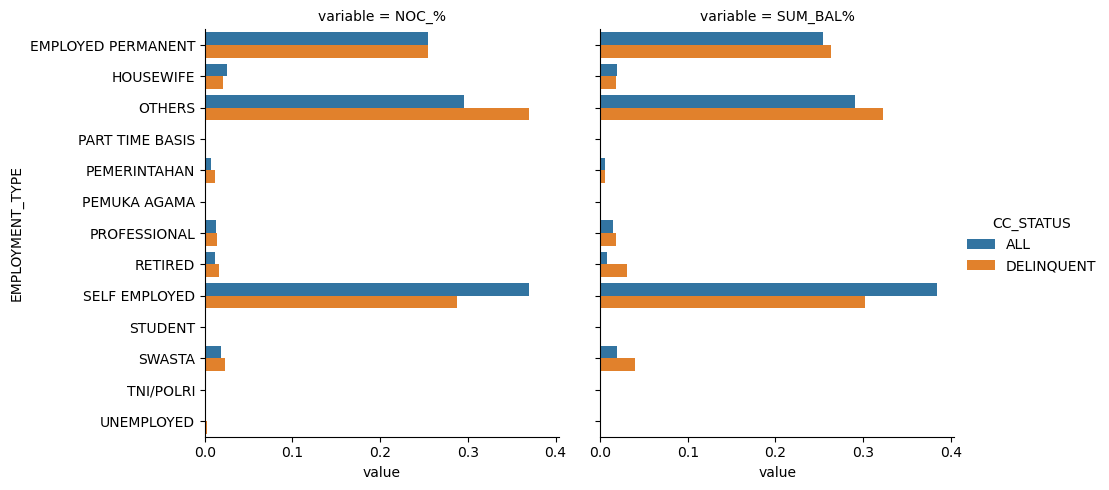

In [150]:
sns.catplot(EMPPlotter, kind='bar',y='EMPLOYMENT_TYPE', x='value', hue='CC_STATUS', col='variable')

In [146]:
EmpGPD

,BASE_DT,SAGA_FLAG,CC_STATUS,EMPLOYMENT_TYPE,NOC,SUM_LMT,SUM_BAL,NOA
0,20231130,NON-SAGA,DELINQUENT,EMPLOYED PERMANENT,333,6.610121e+09,6609254284,441
1,20231130,NON-SAGA,DELINQUENT,HOUSEWIFE,7,1.803111e+08,172228042,9
2,20231130,NON-SAGA,DELINQUENT,OTHERS,268,4.710630e+09,4552209800,353
3,20231130,NON-SAGA,DELINQUENT,PART TIME BASIS,11,6.240432e+07,64934522,11
4,20231130,NON-SAGA,DELINQUENT,PEMERINTAHAN,4,1.355393e+08,126078425,4
...,...,...,...,...,...,...,...,...
829,20241129,SAGA,PERFORMING,SELF EMPLOYED,21497,1.180796e+12,353425202120,40883
830,20241129,SAGA,PERFORMING,STUDENT,7,3.269125e+08,18500,8
831,20241129,SAGA,PERFORMING,SWASTA,1068,5.321844e+10,17514383961,2046
832,20241129,SAGA,PERFORMING,TNI/POLRI,24,1.018038e+09,420503211,43


In [154]:
EmpGPDFiltered = EmpGPD[(EmpGPD['EMPLOYMENT_TYPE'].isin(['EMPLOYED PERMANENT','SELF EMPLOYED','OTHERS'])) &
                        (EmpGPD['CC_STATUS']=='DELINQUENT') & 
                        (EmpGPD['SAGA_FLAG']=='SAGA')]
EmpGPDFiltered['BASE_DT'] = EmpGPDFiltered['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_1240\1298522034.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EmpGPDFiltered['BASE_DT'] = EmpGPDFiltered['BASE_DT'].str[2:6]


In [155]:
EmpGPDFiltered

,BASE_DT,SAGA_FLAG,CC_STATUS,EMPLOYMENT_TYPE,NOC,SUM_LMT,SUM_BAL,NOA
34,2311,SAGA,DELINQUENT,EMPLOYED PERMANENT,115,3.252491e+09,2940877360,182
36,2311,SAGA,DELINQUENT,OTHERS,210,6.692987e+09,6596647493,310
41,2311,SAGA,DELINQUENT,SELF EMPLOYED,157,7.604912e+09,7056196248,241
103,2312,SAGA,DELINQUENT,EMPLOYED PERMANENT,122,3.790113e+09,3423261423,205
105,2312,SAGA,DELINQUENT,OTHERS,219,6.922069e+09,6468654230,304
111,2312,SAGA,DELINQUENT,SELF EMPLOYED,159,8.231604e+09,7819172004,237
171,2401,SAGA,DELINQUENT,EMPLOYED PERMANENT,119,3.842812e+09,3568518301,185
173,2401,SAGA,DELINQUENT,OTHERS,210,7.160078e+09,6729421978,295
179,2401,SAGA,DELINQUENT,SELF EMPLOYED,152,8.275414e+09,7888207614,214
238,2402,SAGA,DELINQUENT,EMPLOYED PERMANENT,115,3.693445e+09,3434098202,156


<Axes: title={'center': 'DELINQUENT SAGA NOC'}, xlabel='BASE_DT', ylabel='NOC'>

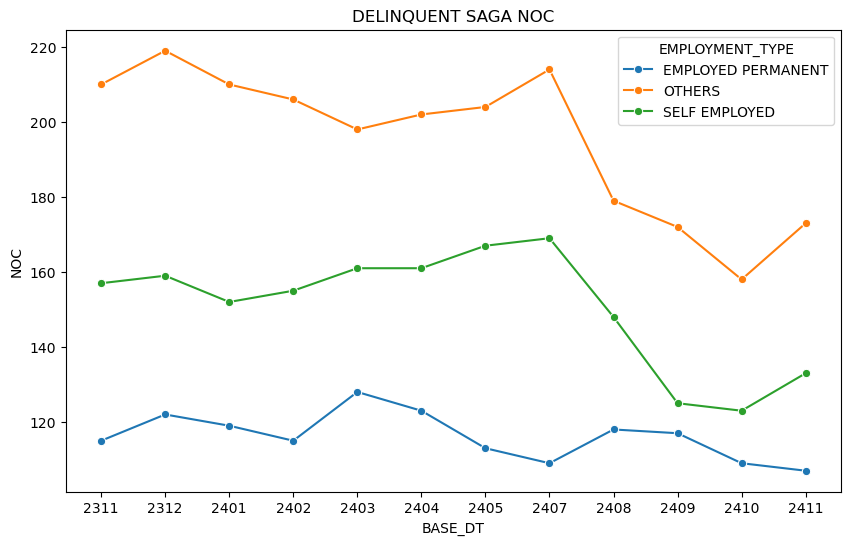

In [157]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("DELINQUENT SAGA NOC")
plt.xlabel("BASE_DT")
plt.ylabel("NOC")
sns.lineplot(data=EmpGPDFiltered, x="BASE_DT", y='NOC', hue='EMPLOYMENT_TYPE', marker="o")

<Axes: title={'center': 'DELINQUENT SAGA MTD_MAX_BAL'}, xlabel='BASE_DT', ylabel='MTD_MAX_BAL'>

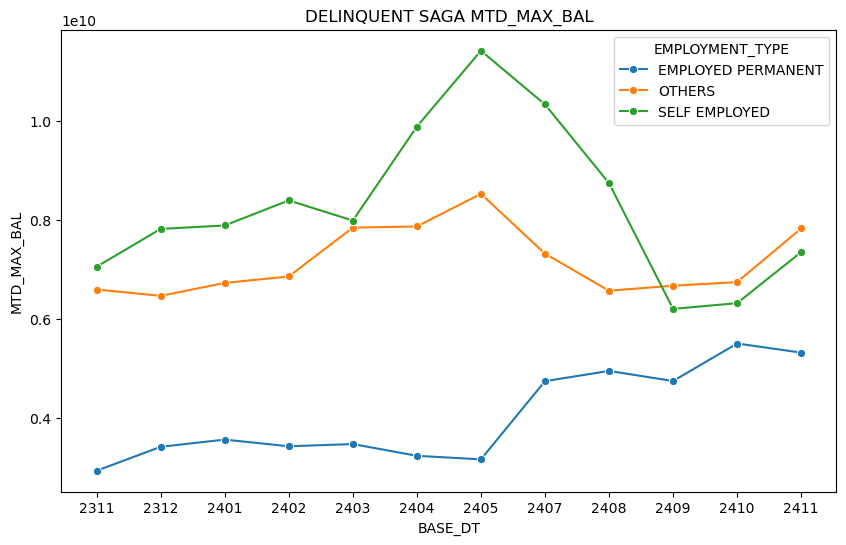

In [158]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("DELINQUENT SAGA MTD_MAX_BAL")
plt.xlabel("BASE_DT")
plt.ylabel("MTD_MAX_BAL")
sns.lineplot(data=EmpGPDFiltered, x="BASE_DT", y='SUM_BAL', hue='EMPLOYMENT_TYPE', marker="o")

In [164]:
EmpGPDFiltered.to_csv(r'D:\Work\SAGA CC Bad Debt\Data\Result\Delinquent SAGA Employment Type.csv')